In [2]:
import re
import csv
import gzip
import json
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from collections import OrderedDict, defaultdict
from nltk.probability import FreqDist as Counter
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27), 'figure.dpi':300})

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
sns.set_style("darkgrid",
        {'axes.spines.bottom': True, 
         'axes.spines.left': True, 
         'axes.spines.right': True, 
         'axes.spines.top': True})
sns.set_palette([sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["amber"]])
mpl.rcParams.update({'font.size': 30})
mpl.rcParams.update({'figure.dpi':300})

In [3]:
categories = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
super_cats = ['person', 'vehicle', 'outdoor', 'animal', 'accessory', 'sports', 'kitchen', 'food', 'furniture', 
              'electronic', 'appliance', 'indoor', 'utensil', 'human', 'cloth', 'cloths', 'clothing', 'people', 
              'persons']
cats = ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book','clock', 'vase', 
        'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'meter', 'bear', 'cell', 'phone', 'wine','glass', 
        'racket', 'baseball', 'glove', 'hydrant', 'drier', 'kite', 'sofa', 'fork', 'adult', 'arms', 'baby', 'bag',
        'ball', 'bananas', 'basket', 'bat', 'batter', 'bike', 'birds', 'board', 'body', 'books', 'bottles', 
        'box', 'boy','bread', 'brush', 'building', 'bunch', 'cabinet', 'camera', 'candle', 'cap', 'carrots', 
        'cars', 'cart', 'case','catcher', 'cell phone', 'chairs', 'child', 'chocolate', 'coat', 'coffee', 
        'computer', 'controller', 'counter','cows', 'cupboard', 'cups', 'curtain', 'cycle', 'desk', 'device', 
        'dining table', 'dish', 'doll', 'door','dress', 'driver', 'equipment', 'eyes', 'fan', 'feet', 'female', 
        'fence', 'fire', 'flag', 'flower', 'flowers','foot', 'frame', 'fridge', 'fruit', 'girl', 'girls', 
        'glasses', 'guy', 'guys', 'hair drier', 'handle', 'hands','hat', 'helmet', 'house', 'jacket', 'jar', 
        'jeans', 'kid', 'kids', 'lady', 'lamp', 'leg', 'legs', 'luggage','machine', 'male', 'man', 'meat', 
        'men', 'mirror', 'mobile', 'monitor', 'mouth', 'mug', 'napkin', 'pan','pants', 'paper', 'pen', 
        'picture', 'pillow', 'plant', 'plate', 'player', 'players', 'pole', 'pot', 'purse', 'rack','racket', 
        'road', 'roof', 'screen', 'shelf', 'shelves', 'shirt', 'shoe', 'shoes', 'short', 'shorts', 'shoulder',
        'signal', 'sign', 'silverware', 'skate', 'ski', 'sky', 'snow', 'soap', 'speaker', 'stairs', 'statue', 
        'stick', 'stool','stove', 'street', 'suit', 'sunglasses', 'suv', 'teddy', 'tennis', 'tent', 'tomato', 
        'towel', 'tower', 'toy','traffic', 'tray', 'tree', 'trees', 't-shirt', 'tshirt', 'vegetable', 'vest', 
        'wall', 'watch', 'wheel', 'wheels','window', 'windows', 'woman', 'women']
colors = ['white', 'red', 'black', 'blue', 'green', 'yellow', 'orange', 'brown', 'pink', 'grey', 'gray', 'dark',
          'purple', 'color', 'colored', 'colour', 'blond', 'beige', 'bright']
sizes = ['small', 'little', 'long', 'large', 'largest', 'big', 'tall', 'smaller', 'bigger', 'biggest', 'tallest']
texture = ['metal', 'silver', 'wood', 'wooden', 'plastic', 'striped', 'liquid']
shape = ['circle', 'rectangle', 'round', 'shape', 'square', 'triangle']
location = ['1st', '2nd', 'third', '3', '3rd', 'four', '4th', 'fourth', '5', '5th', 'five', 'first', 'second',
            'last', 'above', 'across', 'after', 'around', 'at', 'away', 'back', 'background', 'before',
            'behind', 'below', 'beside', 'between', 'bottom', 'center', 'close', 'closer', 'closest',
            'corner', 'directly', 'down', 'edge', 'end', 'entire', 'facing', 'far', 'farthest', 'floor',
            'foreground', 'from', 'front', 'furthest', 'ground', 'hidden', 'in', 'inside', 'left',
            'leftmost', 'middle', 'near', 'nearest', 'next', 'next to', 'off', 'on', 'out', 'outside',
            'over', 'part', 'right', 'rightmost', 'row', 'side', 'smaller', 'top', 'towards', 'under', 'up',
            'upper', 'with']

### Data Loading

In [5]:
data_files = OrderedDict({
    'baseline': 'qgen_baseline_mq8.json',
    'belief': 'qgenbelief_learnspat_ve0ce256_1549303003.520712.pt_valid.json',
    'belief_guesserup': 'qgenbelief_guesserup_learnspat_ve128ce512_1549471823.507809.pt_valid.json'
})
abblation_files = OrderedDict({
    'uniform': 'qgenbelief_uniform_ve64ce64_1552755664.452057.pt_valid.json',
    'allcats': 'qgenbelief_allcats_ve64ce64_1552840530.854645.pt_valid.json'
})
guesser_prob_file = 'guesser_probs.pt'

attn_files = OrderedDict({
    'bl_attn': 'qgen_bl_attn_ve256_1551690326.764065.pt_valid.json',
    'vanilla':'qgenbelief_attn_ve64_1551643188.079412.pt_valid.json',
    'guesserup':'qgenbelief_guesserup_attn_ve256_1551633883.70432.pt_valid.json',
    'learnspat':'qgenbelief_attn_learnspat_ve64_1551643188.073126.pt_valid.json',
    'guesserup_learnspat':'qgenbelief_guesserup_attn_learnspat_ve128_1551617993.664498.pt_valid.json'
})

attn_files_test = OrderedDict({
    'bl_attn': 'qgen_bl_attn_ve256_1551690326.764065.pt_test.json',
    'vanilla':'qgenbelief_attn_ve64_1551643188.079412.pt_test.json',
    'guesserup':'qgenbelief_guesserup_attn_ve256_1551633883.70432.pt_test.json',
    'learnspat':'qgenbelief_attn_learnspat_ve64_1551643188.073126.pt_test.json',
    'guesserup_learnspat':'qgenbelief_guesserup_attn_learnspat_ve128_1551617993.664498.pt_test.json'
})

In [6]:
def load(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

In [7]:
data = OrderedDict()
for label, file in data_files.items():
    data[label] = load(file)

In [8]:
abbl_data = OrderedDict()
for label, file in abblation_files.items():
    abbl_data[label] = load(file)

In [9]:
attn_data = OrderedDict()
for label, file in attn_files.items():
    attn_data[label] = load(file)

In [10]:
attn_data_test = OrderedDict()
for label, file in attn_files_test.items():
    attn_data_test[label] = load(file)

In [11]:
def eval_num_q(data):
    for label in data.keys():
        counts = np.zeros((12))
        for game in data[label].values():
            counts += np.argmax(game['guesser_probs'][1:], axis=1) == game['target_id']

        print(label, np.round(counts / len(data[label])*100, 2))
eval_num_q(attn_data_test)

bl_attn [27.81 35.27 40.45 42.55 43.19 43.13 43.01 42.88 42.48 42.16 41.77 41.34]
vanilla [28.33 36.05 41.54 43.75 44.38 44.75 45.06 44.7  44.28 44.05 43.55 43.39]
guesserup [28.68 37.19 42.87 45.01 45.86 46.04 45.88 45.69 45.33 45.16 44.88 44.46]
learnspat [28.88 38.14 44.29 46.87 47.66 48.3  48.63 48.78 48.53 48.54 48.48 48.28]
guesserup_learnspat [28.96 40.06 48.69 52.42 54.23 54.84 55.11 55.22 55.06 54.98 54.56 54.27]


In [8]:
guesser_data = defaultdict(dict)
d = torch.load(guesser_prob_file)
game_ids = d['game_ids'].tolist()
with gzip.open('../data/guesswhat.valid.jsonl.gz', 'r') as file:
    
    for json_game in file:
        game = json.loads(json_game)
        idx = game_ids.index(game['id'])
        guesser_data[game['id']]['probs'] = d['object_probs'][idx].tolist()
        guesser_data[game['id']]['target_id'] = [o['id'] for o in game['objects']].index(game['object_id'])
        guesser_data[game['id']]['num_questions'] = len(game['qas'])

### Counters

In [9]:
def get_token_counter(data):
    token_counter = Counter()
    for game in data.values():
        token_counter.update(game['dialogue'].split(' '))
            
    return token_counter

In [10]:
def split_dialogue(d):
    d = d[6:]
    d = re.split(' <yes> | <no> | <n/a> ', d)
    d[-1] = d[-1][:d[-1].index('<')-1]
    return d

In [49]:
def belief_question_correlation(data, onetar=False, stop=False):
    
    for label in data.keys():
        count = 0
        norm = 0 
        
        if label == 'baseline':
            k = 'object_probs'
        elif label == 'belief':
            k = 'guesser_probs'
        elif label == 'belief_guesserup':
            k = 'belief_probs'
                
        for game in data[label].values():
            if onetar:
                if game['object_categories'].count(game['object_categories'][game['target_id']]) > 1:
                    continue
           
            dial = split_dialogue(game['dialogue'])
            for i, (question, probs) in enumerate(zip(dial, game[k][:-1])):
                belief_cat = game['object_categories'][np.argmax(probs)]
                if len(set(belief_cat.split(' ')).intersection(set(question.split(' ')))) > 0:
                    count += 1
                norm += 1
                if stop:
                    try:
                        if np.argmax(game.get('guesser_probs', game.get('object_probs'))[i+1]) == game['target_id']:
                            break
                    except:
                        print(label, game.keys())
                        raise
                        
                #if label == 'belief_guesserup':
                #    print(question)
                #    print(belief_cat)
                #    print(norm, count)
            #if label == 'belief_guesserup':
            #    raise
        print(label, norm, count, np.round(count/norm*100,2))
        
belief_question_correlation(data, False, False)
print()
belief_question_correlation(data, False, True)
print()
belief_question_correlation(data, True, False)
print()
belief_question_correlation(data, True, True)

baseline 189912 56964 29.99
belief 189912 95032 50.04
belief_guesserup 189912 80588 42.43

baseline 104086 27206 26.14
belief 97881 42701 43.63
belief_guesserup 92194 36536 39.63

baseline 58912 15355 26.06
belief 58912 28102 47.7
belief_guesserup 58912 30697 52.11

baseline 22320 3831 17.16
belief 20970 7066 33.7
belief_guesserup 17023 8463 49.72


In [92]:
def get_question_counter(data):
    question_counter = Counter()
    for game in data.values():
        question_counter.update(split_dialogue(game['dialogue']))
        
    return question_counter

In [93]:
def get_question_counter_per_round(data, nq=8):
    round_counter = defaultdict(Counter)
    for game in data.values():
        questions = split_dialogue(game['dialogue'])
        for i, q in enumerate(questions):
            round_counter[i].update([q])
    return round_counter

In [94]:
token_counters, question_counters = OrderedDict(), OrderedDict()
for label, d in data.items():
    token_counters[label] = get_token_counter(d)
    question_counters[label] = get_question_counter(d)

### Counter Analysis

In [95]:
def token_counter_analysis(token_counter):
    vocab_size = len(token_counter)
    num_yes = token_counter['<yes>']
    num_no = token_counter['<no>']
    num_not_appl = token_counter['<n/a>']
    
    most_common_words = list()
    for w, c in token_counter.most_common():
        if w not in list(nltk.corpus.stopwords.words('english')) + ['<yes>', '<no>', '<n/a>', '<sos>', '?']:
            most_common_words.append((w, c))
        if c < 1000:
            break

    categories_count = list()
    for c in categories:
        categories_count.append((c, token_counter.get(c, 0)))

    categories_count.sort(key=lambda tup: tup[1], reverse=True)
    
    return {
        'vocab_size': vocab_size,
        'num_yes': num_yes,
        'num_no': num_no,
        'num_not_appl': num_not_appl,
        'most_common_words': most_common_words,
        'categories_count': categories_count
    }

In [96]:
def question_counter_analysis(question_counter):
    num_questions = sum(question_counter.values())
    num_set_questions = len(question_counter)
    
    most_common_questions = list()
    for q, c in question_counter.most_common():
        most_common_questions.append((q, c))
        if c < 1000:
            break
    
    norm_total, norm_rel = 0, 0
    rel_mscococats, rel_supercats, rel_cats, rel_colors, rel_sizes, rel_textures, \
        rel_shapes, rel_locations = 0,0,0,0,0,0,0,0
    total_mscococats, total_supercats, total_cats, total_colors, total_sizes, total_textures, \
        total_shapes, total_locations = 0,0,0,0,0,0,0,0
    
    
    for q, c in question_counter.most_common():

        if len(set(categories).intersection(set(q.split()))) > 0:
            rel_mscococats += 1
            total_mscococats += c
            
        if len(set(super_cats).intersection(set(q.split()))) > 0:
            rel_supercats += 1
            total_supercats += c
            
        if len(set(cats).intersection(set(q.split()))) > 0:
            rel_cats += 1
            total_cats += c
            
        if len(set(colors).intersection(set(q.split()))) > 0:
            rel_colors += 1
            total_colors += c
            
        if len(set(sizes).intersection(set(q.split()))) > 0:
            rel_sizes += 1
            total_sizes += c
            
        if len(set(texture).intersection(set(q.split()))) > 0:
            rel_textures += 1
            total_textures += c
            
        if len(set(shape).intersection(set(q.split()))) > 0:
            rel_shapes += 1
            total_shapes += c
            
        if len(set(location).intersection(set(q.split()))) > 0:
            rel_locations += 1
            total_locations += c
            
        norm_total += c
        norm_rel += 1
        
    return {
        'num_questions': num_questions,
        'num_set_questions': num_set_questions,
        
        'total_mscoco_cats': total_mscococats / norm_total,
        'rel_mscoco_cats': rel_mscococats / norm_rel,
        
        'total_supercats': total_supercats / norm_total,
        'rel_supercats': rel_supercats / norm_rel,
        
        'total_cats': total_cats / norm_total,
        'rel_cats': rel_cats / norm_rel,
        
        'total_colors': total_colors / norm_total,
        'rel_colors': rel_colors / norm_rel,
        
        'total_sizes': total_sizes / norm_total,
        'rel_sizes': rel_sizes / norm_rel,
        
        'total_textures': total_textures / norm_total,
        'rel_textures': rel_textures / norm_rel,
        
        'total_shapes': total_shapes / norm_total,
        'rel_shapes': rel_shapes / norm_rel,
        
        'total_locations': total_locations / norm_total,
        'rel_locations': rel_locations / norm_rel,
        
        'most_common_questions': most_common_questions
    }

In [97]:
token_analysis = OrderedDict()
for label, tk in token_counters.items():
    token_analysis[label] = token_counter_analysis(tk)

In [98]:
question_analysis = OrderedDict()
for label, tk in question_counters.items():
    question_analysis[label] = question_counter_analysis(tk)

In [99]:
def compare_token_analysis(analysis, keys=['vocab_size', 'num_yes', 'num_no', 'num_not_appl'], mc=5):
    labels = list()
    data = np.zeros((len(analysis), len(keys)))
    most_common_words = list()
    most_common_categories = list()
    for l, a in analysis.items():
        for ki, k in enumerate(keys):
            data[len(labels), ki] = a[k]
        labels.append(l)
        
        most_common_words.append(a['most_common_words'][:mc])
        most_common_categories.append(a['categories_count'][:mc])

    df = pd.DataFrame(np.asarray(data), index=labels, columns=keys)
    df['num_yes'] = df['num_yes'] / 189912.0 *100
    df['num_no'] = df['num_no'] / 189912.0 *100
    df['most_common_words'] = most_common_words
    df['most_common_categories'] = most_common_categories

    return df
compare_token_analysis(token_analysis)

vocab_size    num_yes     num_no  num_not_appl  \
baseline               368.0  38.861157  61.135157           7.0   
belief                 368.0  58.301740  41.697207           2.0   
belief_guesserup       449.0  62.635852  37.344665          37.0   

                                                  most_common_words  \
baseline          [(person, 42548), (one, 34888), (right, 23525)...   
belief            [(person, 55074), (whole, 42573), (one, 36064)...   
belief_guesserup  [(one, 49636), (person, 38345), (whole, 33255)...   

                                             most_common_categories  
baseline          [(person, 42548), (chair, 7127), (car, 5207), ...  
belief            [(person, 55074), (car, 8447), (chair, 4892), ...  
belief_guesserup  [(person, 38345), (car, 6500), (chair, 3589), ...

In [100]:
def compare_question_analysis(analysis, 
    keys=['num_questions', 'num_set_questions', 'total_mscoco_cats', 'total_supercats', 'total_cats', 'total_colors', 'total_locations'],mc=5):
    labels = list()
    data = np.zeros((len(analysis), len(keys)))
    most_common_questions = list()
    for l, a in analysis.items():
        for ki, k in enumerate(keys):
            data[len(labels), ki] = a[k]
        labels.append(l)
        
        most_common_questions.append(a['most_common_questions'][:mc])

    df = pd.DataFrame(np.asarray(data), index=labels, columns=keys)
    df['most_common_questions'] = most_common_questions

    return df

compare_question_analysis(question_analysis)

num_questions  num_set_questions  total_mscoco_cats  \
baseline               189912.0             2145.0           0.501585   
belief                 189912.0             1896.0           0.585582   
belief_guesserup       189912.0             3161.0           0.456891   

                  total_supercats  total_cats  total_colors  total_locations  \
baseline                 0.263006    0.538750      0.083802         0.354454   
belief                   0.316784    0.490317      0.068574         0.398132   
belief_guesserup         0.225110    0.485293      0.079790         0.452920   

                                              most_common_questions  
baseline          [(is it a person ?, 15915), (is it the one on ...  
belief            [(is it the whole person ?, 16473), (is it a p...  
belief_guesserup  [(is it the one on the left ?, 19483), (is it ...

In [101]:
q_length = dict()
for label in question_counters.keys():
    length = list()
    for q, c in question_counters[label].items():
        length += [len(q.split())]*c
    q_length[label] = length
    print(label, np.mean(length), np.std(length))
    
print()
for k1 in q_length.keys():
    for k2 in q_length.keys():
        if k1 != k2:
        
            print(k1, k2, stats.ttest_ind(q_length[k1], q_length[k2]))

baseline 6.320137748009604 1.7235240402440368
belief 6.58546063439909 1.7856084808334478
belief_guesserup 6.602737057163318 1.7766634491337636

baseline belief Ttest_indResult(statistic=-46.5904646854138, pvalue=0.0)
baseline belief_guesserup Ttest_indResult(statistic=-49.75306054830438, pvalue=0.0)
belief baseline Ttest_indResult(statistic=46.5904646854138, pvalue=0.0)
belief belief_guesserup Ttest_indResult(statistic=-2.9889279289057464, pvalue=0.002799760660773146)
belief_guesserup baseline Ttest_indResult(statistic=49.75306054830438, pvalue=0.0)
belief_guesserup belief Ttest_indResult(statistic=2.9889279289057464, pvalue=0.002799760660773146)


### Task Success by Round Analysis

23739
SOLVED
Games Solved
baseline 10122
belief 12056
belief_guesserup 13284
Union
baseline & belief & belief_guesserup 0.28703820716963646

Intersections
baseline & belief - belief_guesserup 0.03622730527823413
baseline & belief_guesserup - belief 0.05514132861535869
belief & belief_guesserup - baseline 0.1259530730022326
--------------------------------------------------------------------------------
FAILED
Games Solved
baseline 13617
belief 11683
belief_guesserup 10455
Union
baseline & belief & belief_guesserup 0.29756940056447195

Intersections
baseline & belief - belief_guesserup 0.0914528834407515
baseline & belief_guesserup - belief 0.05863768482244408
belief & belief_guesserup - baseline 0.04798011710687055
--------------------------------------------------------------------------------


/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


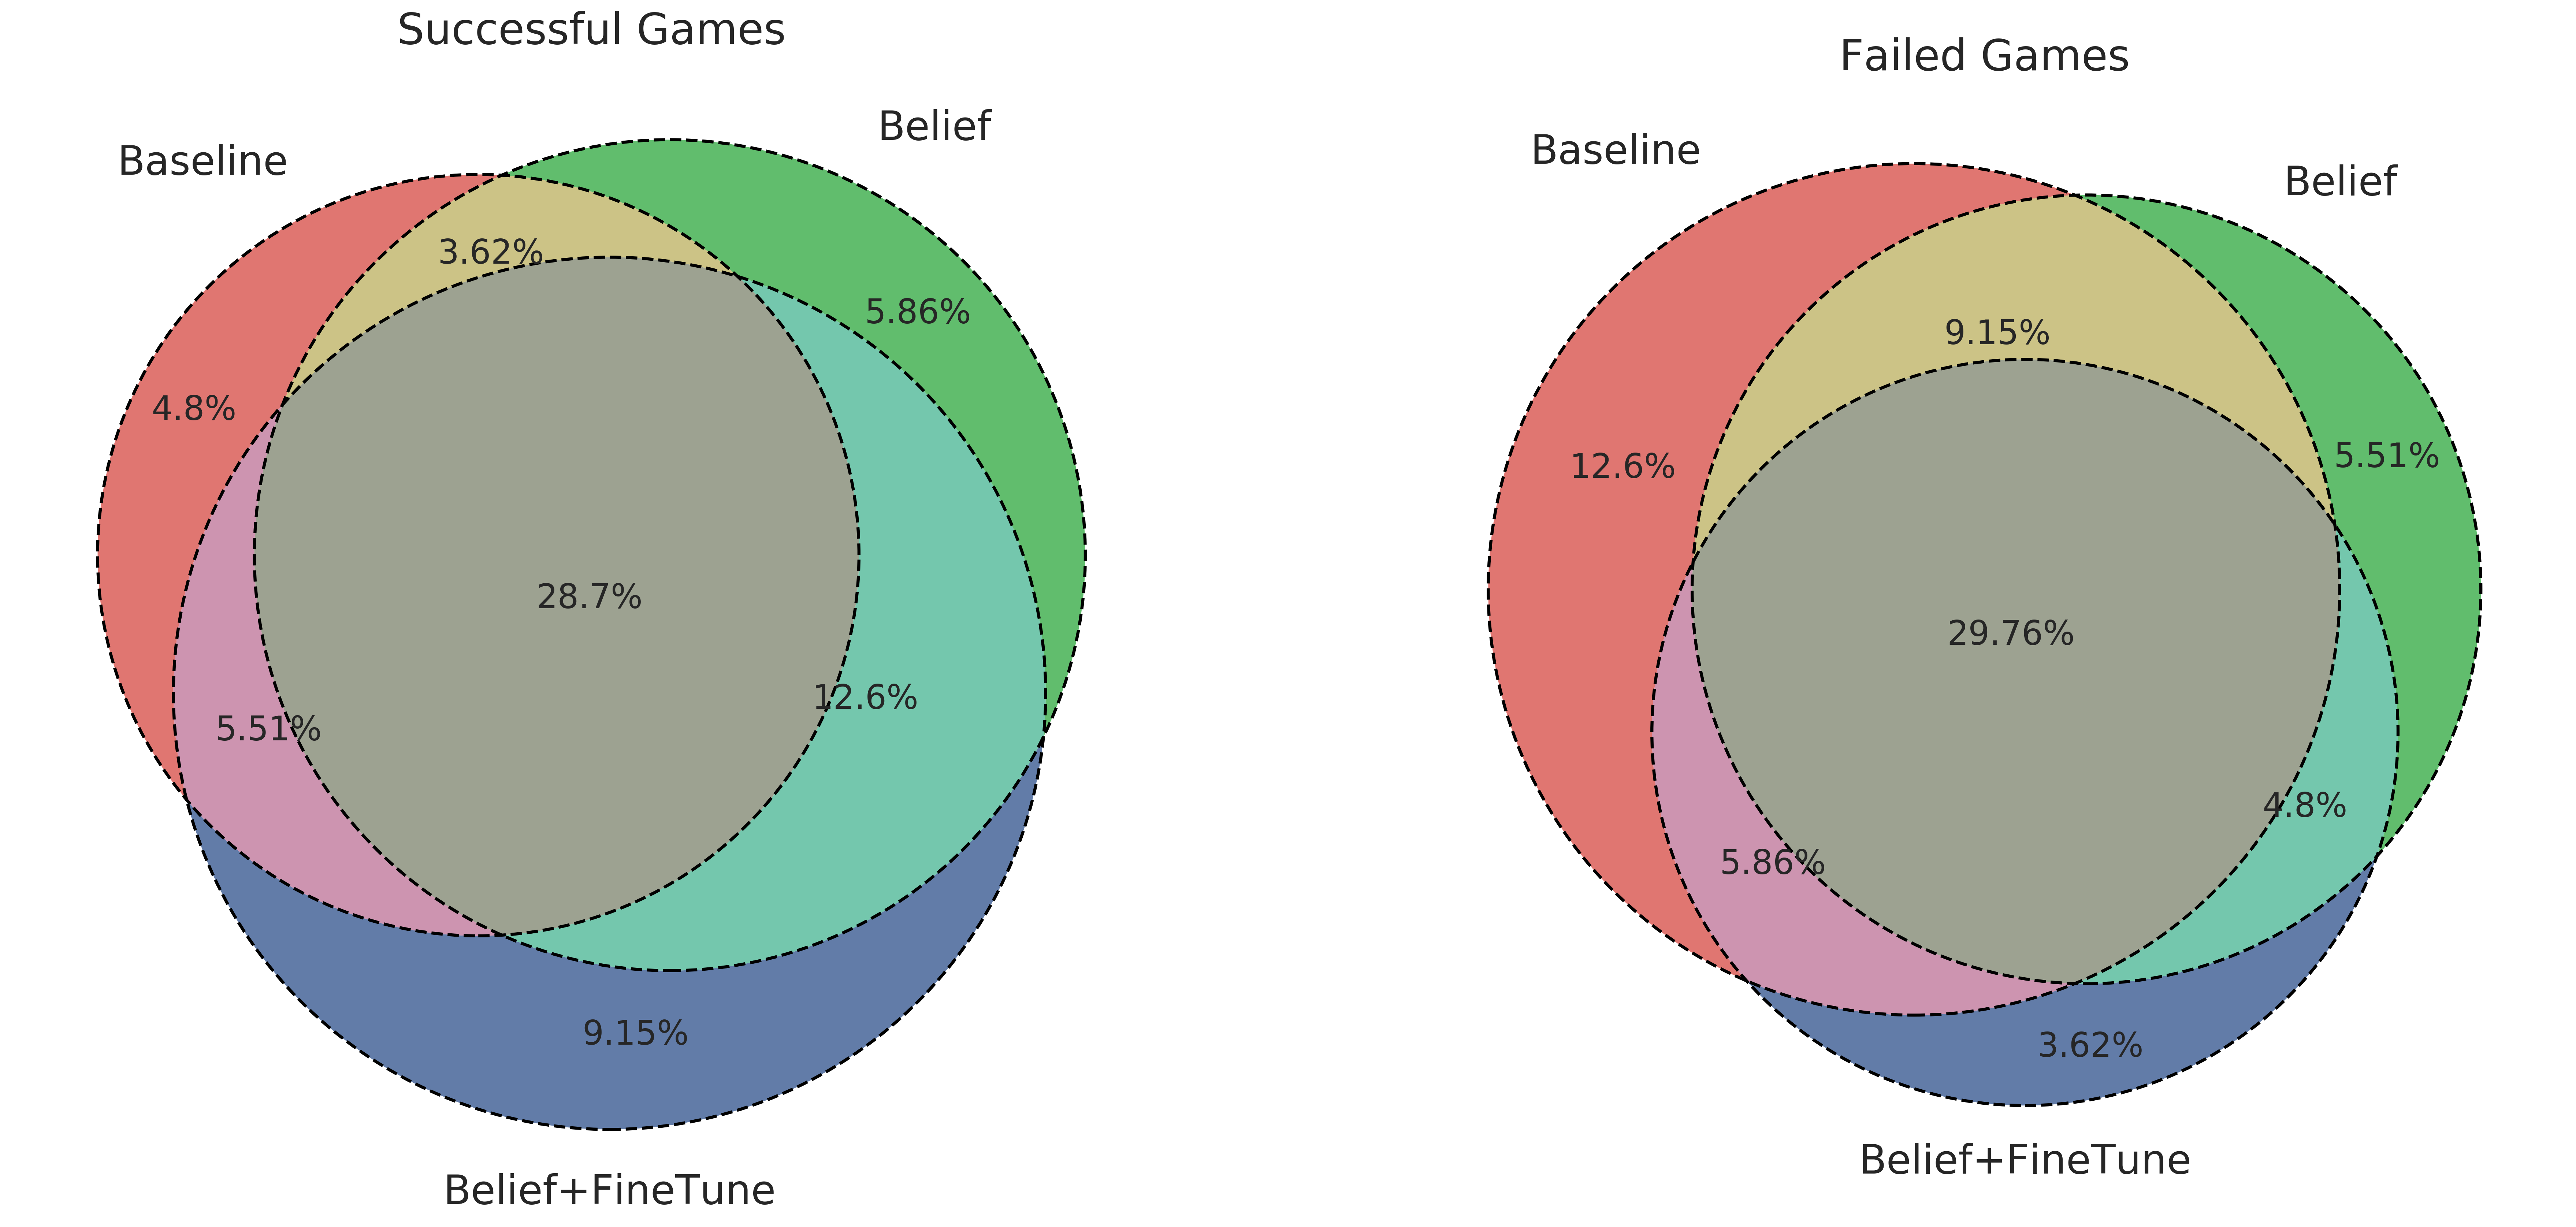

In [139]:
def compare_games_solved_failed(data):
    games_solved, games_failed = defaultdict(set), defaultdict(set)
    for label, d in data.items():
        for game_id, game in d.items():
            if game['target_id'] == game['prediction']:
                games_solved[label].add(game_id)
            else:
                games_failed[label].add(game_id)        
    
    fig, ax = plt.subplots(ncols=2, figsize=(30,20))
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

    mpl.rc('font', **font)
    n_games = len(data[label])
    print(n_games)
    for i, analysis in enumerate(['solved', 'failed']):
        print(analysis.upper())
        s = games_solved if analysis == 'solved' else games_failed
        
        labels = list(s.keys())
        print("Games Solved")
        for l in labels:
            print(l, len(s[l]))
        
        
        print("Union")
        print(labels[0] + " & " + labels[1] + " & " + labels[2],
              len(s[labels[0]] & s[labels[1]] & s[labels[2]]) / n_games)

        print()
        print("Intersections")
        print(labels[0] + " & " + labels[1] + " - " + labels[2],
              len(s[labels[0]] & s[labels[1]] - s[labels[2]]) / n_games)

        print(labels[0] + " & " + labels[2] + " - " + labels[1],
              len(s[labels[0]] & s[labels[2]] - s[labels[1]]) / n_games)

        print(labels[1] + " & " + labels[2] + " - " + labels[0],
              len(s[labels[1]] & s[labels[2]] - s[labels[0]]) / n_games)

        with plt.rc_context({'figure.dpi':20}):
            v = venn3([s[labels[0]], s[labels[1]], s[labels[2]]],
                      set_labels=['Baseline', 'Belief', 'Belief+FineTune'], ax=ax[i], 
                  set_colors=sns.color_palette()[:7], alpha=0.8, 
                subset_label_formatter=lambda x: str(np.round(x/n_games * 100,2)) + '%')
            if i == 0:
                ax[i].set_title('Successful Games', fontdict={'fontsize':28})
            else:
                ax[i].set_title('Failed Games', fontdict={'fontsize':28})
            c = venn3_circles([s[labels[0]], s[labels[1]], s[labels[2]]], linestyle='dashed', ax=ax[i])


            
        print("-"*80)
    #with plt.rc_context({'figure.dpi':100}):
        #plt.show()
    plt.show()
compare_games_solved_failed(data)

In [22]:
def guesser_diff(data):
    dfs = list()
    for label, d in data.items():
        dist = list()
        for game in d.values():
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            assert len(game[k][:-1]) == 8
            for qi, (p_prev, p) in enumerate(zip(game[k][:-1], game[k][1:])):
                assert len(p) > 0
                dist.append(np.sum(np.square(np.asarray(p_prev)-np.asarray(p))) / len(p))
        df = pd.DataFrame(np.asarray(dist), columns=['dist'], index=range(len(dist)))
        df['model'] = label
        df['question'] = np.arange(0, 8).repeat(len(dist)/8)
        dfs.append(df)
    df = pd.concat(dfs)
    return df
df = guesser_diff(data)

/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


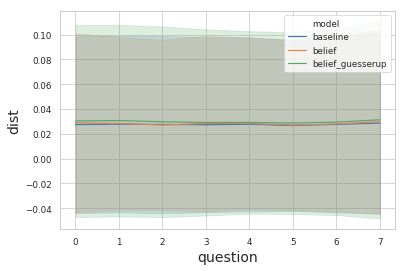

In [23]:
#df_bl = df[df['model']=='baseline'].drop(columns=['model'])
sns.lineplot(data=df, hue='model', y='dist', x='question', ci='sd')

In [24]:
for i in range(8):
    a = df[(df['model']=='belief') & (df['question']==i)]['dist']
    print(i, a.mean(), a.std())

0 0.02883112852420167 0.0722880796643142
1 0.02828202224663812 0.06976259470874209
2 0.027015811242504004 0.06881736521603005
3 0.028336009124550136 0.07081901742031732
4 0.028207695987664365 0.06920822366755276
5 0.027012199339560852 0.06890131607114201
6 0.0279201068407853 0.07041343854367933
7 0.029674036865213266 0.07451699118116187


/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


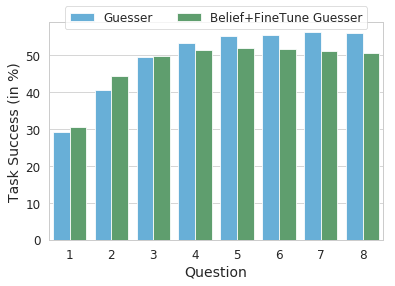

In [25]:
def fine_tune_comp(data):
    guesser_probs = np.zeros((8, 1))
    belief_probs = np.zeros((8, 1))
    norm = 0
    for game in data['belief_guesserup'].values():
        for i in range(1, 9):
            if np.argmax(game['guesser_probs'][i]) == game['target_id']:
                guesser_probs[i-1] += 1
            if np.argmax(game['belief_probs'][i]) == game['target_id']:
                belief_probs[i-1] += 1
        norm += 1
    guesser_probs = guesser_probs/norm*100
    belief_probs = belief_probs/norm*100
    df_guesser = pd.DataFrame(guesser_probs, columns=['v'])
    df_guesser['p'] = 'guesser'
    df_guesser['q'] = list(range(1,9))
    df_belief = pd.DataFrame(belief_probs, columns=['v'])
    df_belief['p'] = 'belief'
    df_belief['q'] = list(range(1,9))
    df = pd.concat([df_guesser, df_belief])
    fig, ax = plt.subplots()
    sns.barplot(data=df, x='q', y='v', hue='p', ax=ax, palette=("#56B4E9", "#55A868"))
    ax.set_ylabel('Task Success (in %)')
    ax.set_xlabel('Question')
    ax.tick_params('both', labelsize=12)
    ax.legend(ax.get_legend_handles_labels()[0], ['Guesser', 'Belief+FineTune Guesser'],
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              fancybox=True, shadow=False, ncol=2, facecolor='white', prop={'size': 12})
fine_tune_comp(data)

Games Solved
belief 12056
uniform 11018
allcats 10628
Union
belief & uniform & allcats 0.28202535911369475

Intersections
belief & uniform - allcats 0.08121656346097139
belief & allcats - uniform 0.06280803740679894
uniform & allcats - belief 0.045494755465689374
--------------------------------------------------------------------------------


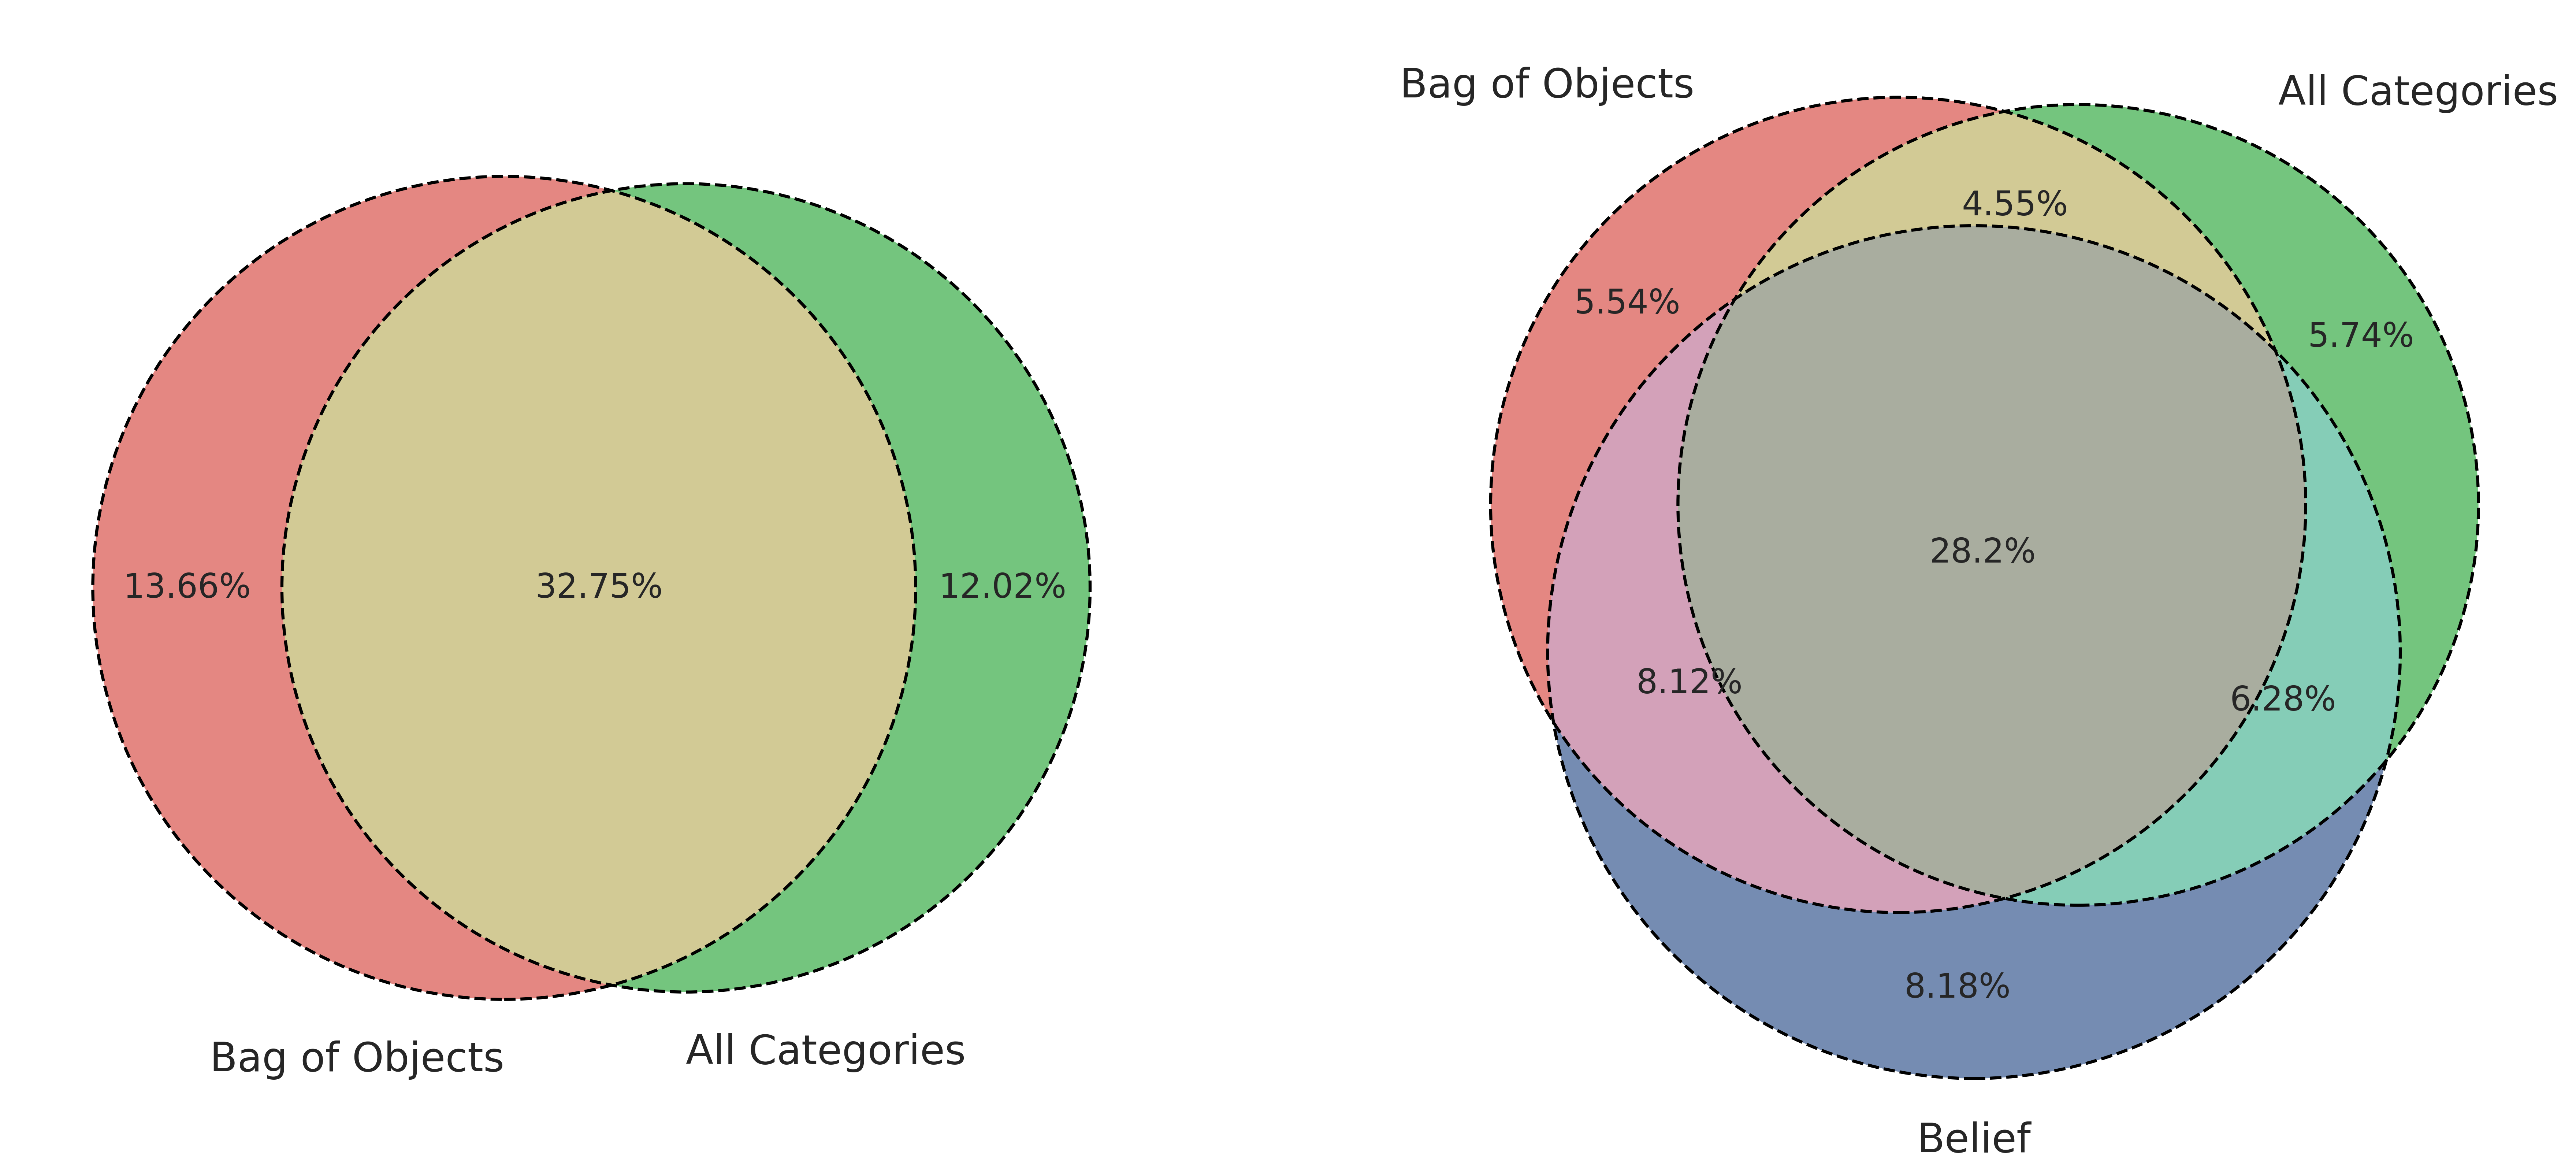

aaaaaaa 3597


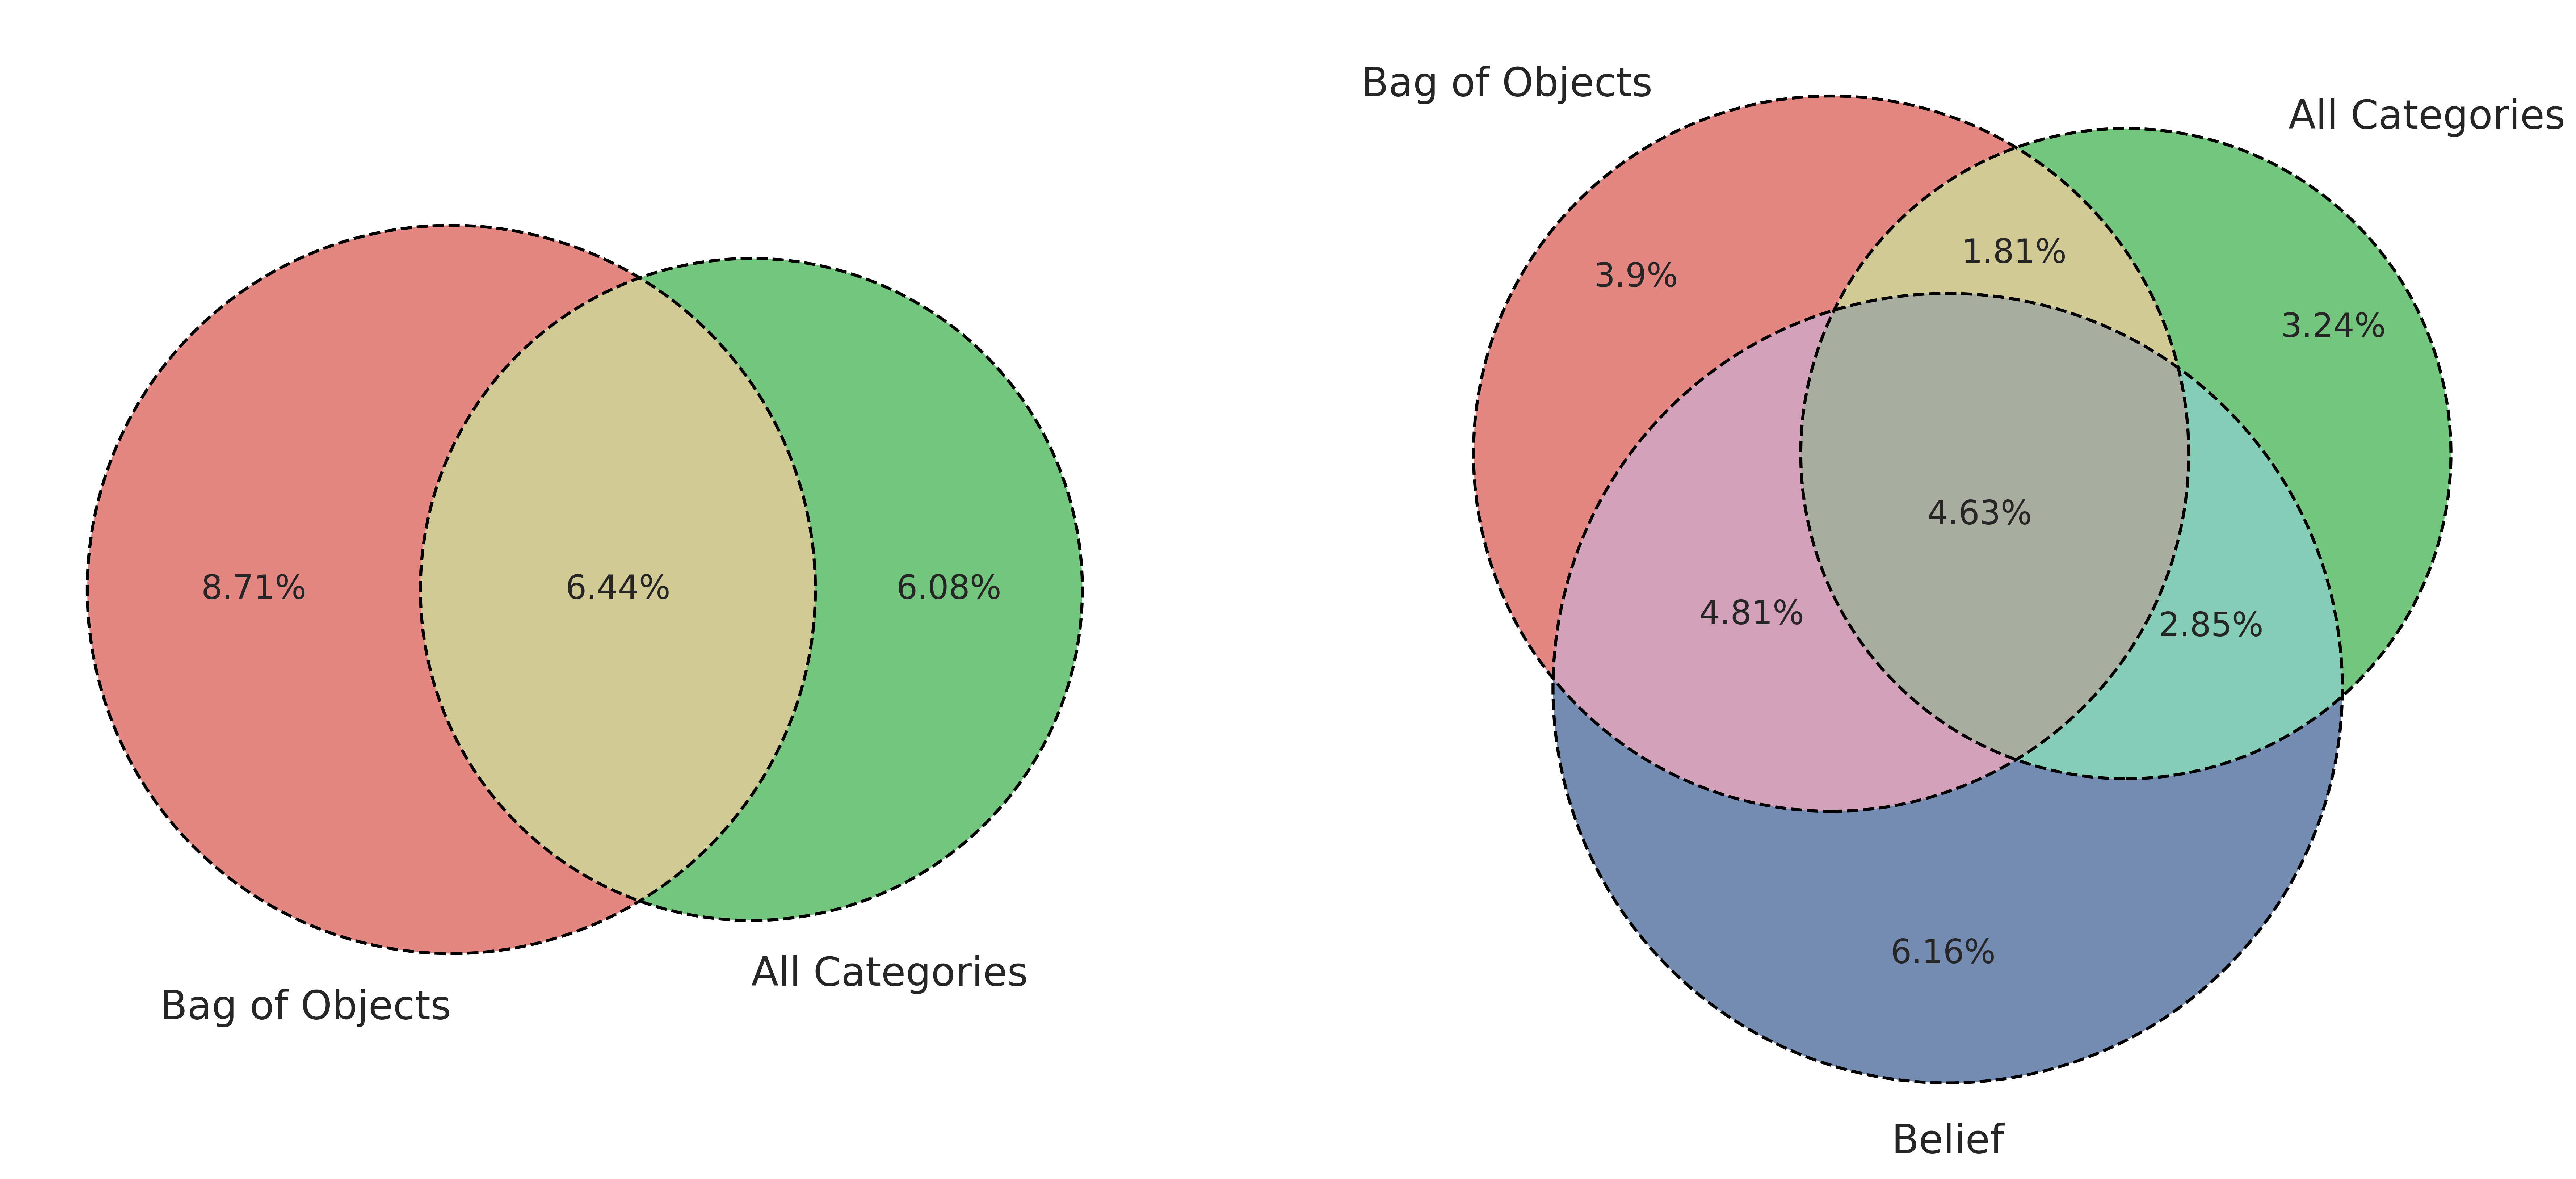

In [147]:
def abbl_venn(abbl_data, data):
    
    games_solved, games_failed = defaultdict(set), defaultdict(set)
    for label in data.keys():
        for game_id, game in data[label].items():
            if game['target_id'] == game['prediction']:
                games_solved[label].add(game_id)
            else:
                games_failed[label].add(game_id)   
    n_games = len(data['baseline'])
    
    for label, d in abbl_data.items():
        for game_id, game in d.items():
            #if game['target_id'] == game['prediction']:
            if game['success']:
                games_solved[label].add(game_id)
            else:
                games_failed[label].add(game_id)  
    
    fig, ax = plt.subplots(ncols=2, figsize=(30,20))
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

    mpl.rc('font', **font)
    
    i = 0
    s = games_solved 
    labels = ['belief', 'uniform', 'allcats']
    v = venn2([s[labels[1]], s[labels[2]]], set_labels=['Bag of Objects', 'All Categories'], ax=ax[i], 
              set_colors=sns.color_palette()[:7], alpha=0.7, 
                subset_label_formatter=lambda x: str(np.round(x/n_games * 100,2)) + '%')
    c = venn2_circles([s[labels[1]], s[labels[2]]], linestyle='dashed', ax=ax[i])

        
    i = 1    
    print("Games Solved")
    for l in labels:
        print(l, len(s[l]))


    print("Union")
    print(labels[0] + " & " + labels[1] + " & " + labels[2],
          len(s[labels[0]] & s[labels[1]] & s[labels[2]]) / n_games)

    print()
    print("Intersections")
    print(labels[0] + " & " + labels[1] + " - " + labels[2],
          len(s[labels[0]] & s[labels[1]] - s[labels[2]]) / n_games)

    print(labels[0] + " & " + labels[2] + " - " + labels[1],
          len(s[labels[0]] & s[labels[2]] - s[labels[1]]) / n_games)

    print(labels[1] + " & " + labels[2] + " - " + labels[0],
          len(s[labels[1]] & s[labels[2]] - s[labels[0]]) / n_games)

    with plt.rc_context({'figure.dpi':20}):
        v = venn3([s[labels[1]], s[labels[2]], s[labels[0]]],
                  set_labels=['Bag of Objects', 'All Categories', 'Belief'], ax=ax[i], 
              set_colors=sns.color_palette()[:7], alpha=0.7, 
            subset_label_formatter=lambda x: str(np.round(x/n_games * 100,2)) + '%')
        #if i == 0:
        #    ax[i].set_title('Successful Games')
        #else:
        #    ax[i].set_title('Failed Games')
        c = venn3_circles([s[labels[1]], s[labels[2]], s[labels[0]]], linestyle='dashed', ax=ax[i])


            
        print("-"*80)
    with plt.rc_context({'figure.dpi':100}):
        plt.show()
        
    fig, ax = plt.subplots(ncols=2, figsize=(30,20))
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
        
    i=0
    print("aaaaaaa",len(s[labels[1]]-s['baseline']))
    v = venn2([s[labels[1]]-s['baseline'], s[labels[2]]-s['baseline']],
              set_labels=['Bag of Objects', 'All Categories'], ax=ax[i], 
              set_colors=sns.color_palette()[:7], alpha=0.7, 
                subset_label_formatter=lambda x: str(np.round(x/n_games * 100,2)) + '%')
    c = venn2_circles([s[labels[1]]-s['baseline'], s[labels[2]]-s['baseline']], linestyle='dashed', ax=ax[i])
    i=1
    with plt.rc_context({'figure.dpi':20}):
        v = venn3([s[labels[1]]-s['baseline'], s[labels[2]]-s['baseline'], s[labels[0]]-s['baseline']],
                  set_labels=['Bag of Objects', 'All Categories', 'Belief'], ax=ax[i], 
              set_colors=sns.color_palette()[:7], alpha=0.7, 
            subset_label_formatter=lambda x: str(np.round(x/n_games * 100,2)) + '%')
        #if i == 0:
        #    ax[i].set_title('Successful Games')
        #else:
        #    ax[i].set_title('Failed Games')
        c = venn3_circles([s[labels[1]]-s['baseline'], s[labels[2]]-s['baseline'],s[labels[0]]-s['baseline']],
                          linestyle='dashed', ax=ax[i])
        
    with plt.rc_context({'figure.dpi':100}):
        plt.show()
        
abbl_venn(abbl_data, data)

In [27]:
def size(bbox):

    #x = bbox[1] - bbox[0]
    #y = bbox[2] - bbox[3]
    #print(bbox)
    #print(x)
    #print(y)
    #print(x*y)
    #raise
    x = bbox[2]
    y = bbox[3]
    if x*y < 0:
        print(".")
    return np.log(x*y)

def a(data):
    
    num_obj_all = list()
    set_obj_all = list()
    sizes_all = list()
    num_tar_all = list()
    categories_all = Counter()
    games_solved, games_failed = defaultdict(set), defaultdict(set)
    for label, d in data.items():
        # k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
        for game_id, game in d.items():
            if game['target_id'] == game['prediction']:
                games_solved[label].add(game_id)
            else:
                games_failed[label].add(game_id)
                
            if label == 'baseline':
                num_obj_all.append(len(game['object_categories']))
                set_obj_all.append(len(set(game['object_categories'])))
                sizes_all.append(size(game['bbox'][game['target_id']]))
                num_tar_all.append(
                        game['object_categories'].count(game['object_categories'][game['target_id']]))
                categories_all.update(game['object_categories'])
                
    """
    games_only_bl_failes = games_solved['belief']
    print(len(games_only_bl_failes))
    num_obj_all = list()
    set_obj_all = list()
    num_tar_all = list()
    sizes_all = list()
    categories = Counter()
    for g in games_only_bl_failes:
        game = data['baseline'][g]
        num_obj_all.append(len(game['object_categories']))
        set_obj_all.append(len(set(game['object_categories'])))
        sizes_all.append(size(game['bbox'][game['target_id']]))
        num_tar_all.append(game['object_categories'].count(game['object_categories'][game['target_id']]))
        categories_all.update(game['object_categories'])
    """
                
    games_only_bl_failes = games_solved['belief_guesserup']
    print(len(games_only_bl_failes))
    num_obj = list()
    set_obj = list()
    num_tar = list()
    sizes = list()
    categories = Counter()
    for g in games_only_bl_failes:
        game = data['baseline'][g]
        num_obj.append(len(game['object_categories']))
        set_obj.append(len(set(game['object_categories'])))
        sizes.append(size(game['bbox'][game['target_id']]))
        num_tar.append(game['object_categories'].count(game['object_categories'][game['target_id']]))
        categories.update(game['object_categories'])
        
    
    print("All gams")
    print("num obj", np.round(np.mean(num_obj_all), 4), np.round(np.std(num_obj_all), 4), 
          stats.ttest_ind(num_obj_all,num_obj,equal_var=False))
    print("set obj", np.round(np.mean(set_obj_all), 4), np.round(np.std(set_obj_all), 4), 
          stats.ttest_ind(set_obj_all,set_obj,equal_var=False))
    print("num tar", np.round(np.mean(num_tar_all), 4), np.round(np.std(num_tar_all), 4), 
          stats.ttest_ind(num_tar_all,num_tar,equal_var=False))
    print("obj siz", np.round(np.mean(sizes_all), 4), np.round(np.std(sizes_all), 4), 
          stats.ttest_ind(sizes_all,sizes,equal_var=False))
    print("top cats", categories_all.most_common(10))
    print("---")
    print("BL fails")
    print("num obj", np.round(np.mean(num_obj), 4), np.round(np.std(num_obj), 4), 
          stats.ttest_ind(num_obj,num_obj_all,equal_var=False))
    print("set obj", np.round(np.mean(set_obj), 4), np.round(np.std(set_obj), 4), 
          stats.ttest_ind(set_obj,set_obj_all,equal_var=False))
    print("num tar", np.round(np.mean(num_tar), 4), np.round(np.std(num_tar), 4), 
          stats.ttest_ind(num_tar,num_tar_all,equal_var=False))
    print("obj siz", np.round(np.mean(sizes), 4), np.round(np.std(sizes), 4), 
          stats.ttest_ind(sizes,sizes_all,equal_var=False))
    print("top cats", categories.most_common(10))
                
a(data)

13284
All gams
num obj 8.5395 4.6664 Ttest_indResult(statistic=31.315305353520543, pvalue=6.941313137758041e-212)
set obj 3.4903 1.7221 Ttest_indResult(statistic=-0.8735219736585993, pvalue=0.3823858685461393)
num tar 3.9853 3.5913 Ttest_indResult(statistic=46.11413551387765, pvalue=0.0)
obj siz 8.6388 2.0011 Ttest_indResult(statistic=-20.229511546950974, pvalue=2.485682563837155e-90)
top cats [('person', 62709), ('car', 12132), ('chair', 7302), ('book', 6641), ('bottle', 6195), ('cup', 4877), ('bowl', 3807), ('dining table', 3627), ('boat', 2813), ('handbag', 2752)]
---
BL fails
num obj 7.0676 4.1427 Ttest_indResult(statistic=-31.315305353520543, pvalue=6.941313137758041e-212)
set obj 3.5059 1.6149 Ttest_indResult(statistic=0.8735219736585993, pvalue=0.3823858685461393)
num tar 2.5181 2.4957 Ttest_indResult(statistic=-46.11413551387765, pvalue=0.0)
obj siz 9.0807 2.024 Ttest_indResult(statistic=20.229511546950974, pvalue=2.485682563837155e-90)
top cats [('person', 27446), ('car', 5291

In [28]:
d = [1,1,2,3,5,1,5,2,5,1,1]
print(np.mean(d), np.std(d))

2.4545454545454546 1.6713433009863852


In [29]:
def b(data):
    
    num_obj_all = list()
    set_obj_all = list()
    sizes_all = list()
    num_tar_all = list()
    categories_all = Counter()
    games_solved, games_failed = defaultdict(set), defaultdict(set)
    for label, d in data.items():
        # k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
        for game_id, game in d.items():
            #if game['target_id'] == game['prediction']:
            if game['success']:
                games_solved[label].add(game_id)
            else:
                games_failed[label].add(game_id)
                
            if label == 'uniform':
                num_obj_all.append(len(game['object_categories']))
                set_obj_all.append(len(set(game['object_categories'])))
                sizes_all.append(size(game['bbox'][game['target_id']]))
                num_tar_all.append(
                        game['object_categories'].count(game['object_categories'][game['target_id']]))
                categories_all.update(game['object_categories'])
                
    games_only_bl_failes = games_solved['allcats'] - games_solved['uniform']
    print(len(games_only_bl_failes))
    num_obj = list()
    set_obj = list()
    num_tar = list()
    sizes = list()
    categories = Counter()
    for g in games_only_bl_failes:
        game = data['uniform'][g]
        num_obj.append(len(game['object_categories']))
        set_obj.append(len(set(game['object_categories'])))
        sizes.append(size(game['bbox'][game['target_id']]))
        num_tar.append(game['object_categories'].count(game['object_categories'][game['target_id']]))
        categories.update(game['object_categories'])
        
    
    print("All gams")
    print("num obj", np.mean(num_obj_all), np.std(num_obj_all))
    print("set obj", np.mean(set_obj_all), np.std(set_obj_all))
    print("num tar", np.mean(num_tar_all), np.std(num_tar_all))
    print("obj siz", np.mean(sizes_all), np.std(sizes_all))
    print("top cats", categories_all.most_common(10))
    print("---")
    print("BL fails")
    print("num obj", np.mean(num_obj), np.std(num_obj))
    print("set obj", np.mean(set_obj), np.std(set_obj))
    print("num tar", np.mean(num_tar), np.std(num_tar))
    print("obj siz", np.mean(sizes), np.std(sizes))
    print("top cats", categories.most_common(10))
                
b(abbl_data)

2853
All gams
num obj 8.539534100004213 4.6664363915393
set obj 3.4902902396899615 1.7220933841309949
num tar 3.9852984540208096 3.5912744486677295
obj siz 8.638842568922753 2.0011173148935524
top cats [('person', 62709), ('car', 12132), ('chair', 7302), ('book', 6641), ('bottle', 6195), ('cup', 4877), ('bowl', 3807), ('dining table', 3627), ('boat', 2813), ('handbag', 2752)]
---
BL fails
num obj 8.430073606729758 4.4265750882320924
set obj 3.612688398177357 1.8088675021608507
num tar 3.7507886435331232 3.2050942366939923
obj siz 8.66400631859747 1.887123294223006
top cats [('person', 7195), ('car', 1663), ('chair', 1010), ('bottle', 634), ('book', 634), ('cup', 629), ('bowl', 530), ('dining table', 493), ('handbag', 418), ('truck', 402)]


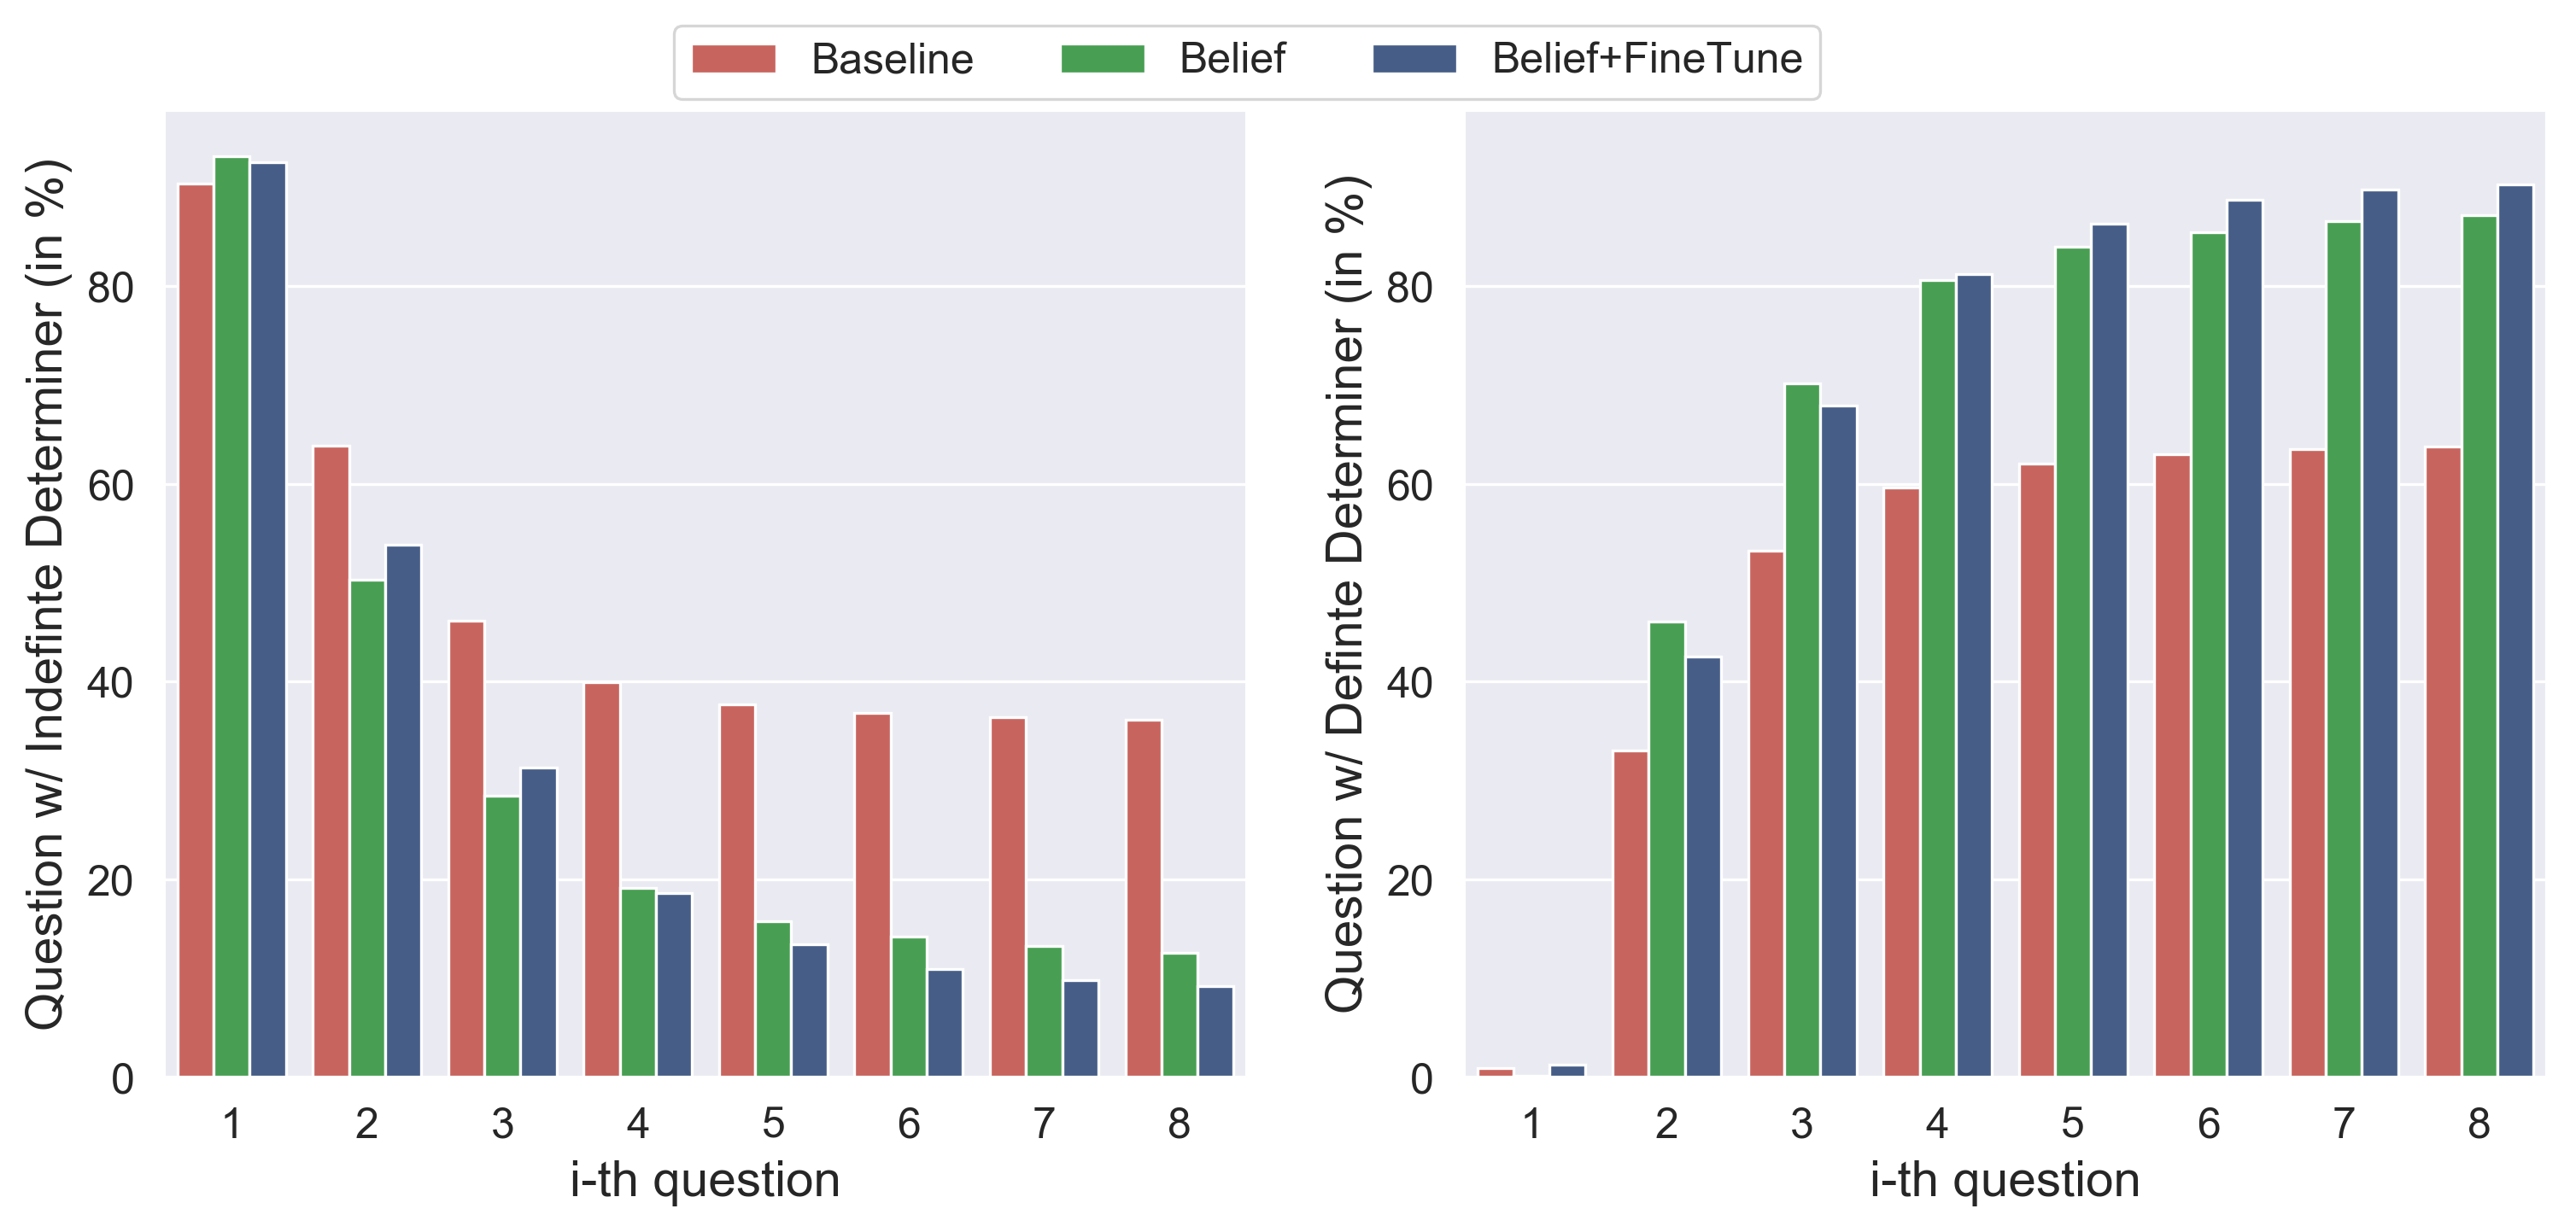

In [107]:
def plot_questions_by_determiner(data, nq=8):
    dfs = list()
    for label, d in data.items():
        counts = np.zeros((nq, 2))
        norm = np.zeros((nq, 1))
        for game in d.values():
            dial = split_dialogue(game['dialogue'])
            for i, q in enumerate(dial):
                if set(['a', 'an', 'any']).intersection(set(q.split())):
                    counts[i, 0] += 1
                if set(['the']).intersection(set(q.split())):
                    counts[i, 1] += 1
                norm[i] += 1
        df = pd.DataFrame(counts/norm*100, columns=['undet', 'det'], index=list(range(1, nq+1)))
        df['model'] = label
        df['i-th question'] = df.index
        dfs.append(df)
        
    df = pd.concat(dfs)
    
    df = pd.concat(dfs)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    
    sns.barplot(x='i-th question', y='undet', hue='model', data=df, ax=ax1)


    ax1.set_ylabel('Question w/ Indefinte Determiner (in %)')
    ax1.legend(ax1.get_legend_handles_labels()[0], ['Baseline', 'Belief', 'Belief+FineTune'] ,
              loc='upper center', bbox_to_anchor=(1, 1.11),
              fancybox=True, shadow=False, ncol=3, facecolor='white', prop={'size': 12})
    ax1.tick_params('both', labelsize=12)
    
    sns.barplot(x='i-th question', y='det', hue='model', data=df, ax=ax2)

    ax2.set_ylabel('Question w/ Definte Determiner (in %)')
    ax2.get_legend().remove()
    ax2.tick_params('both', labelsize=12)
    ax2.yaxis.set_tick_params(which='both', labelleft=True)
   
    #plt.subplots_adjust(wspace=0.1)
    plt.show()
    
    return df
df = plot_questions_by_determiner(data)

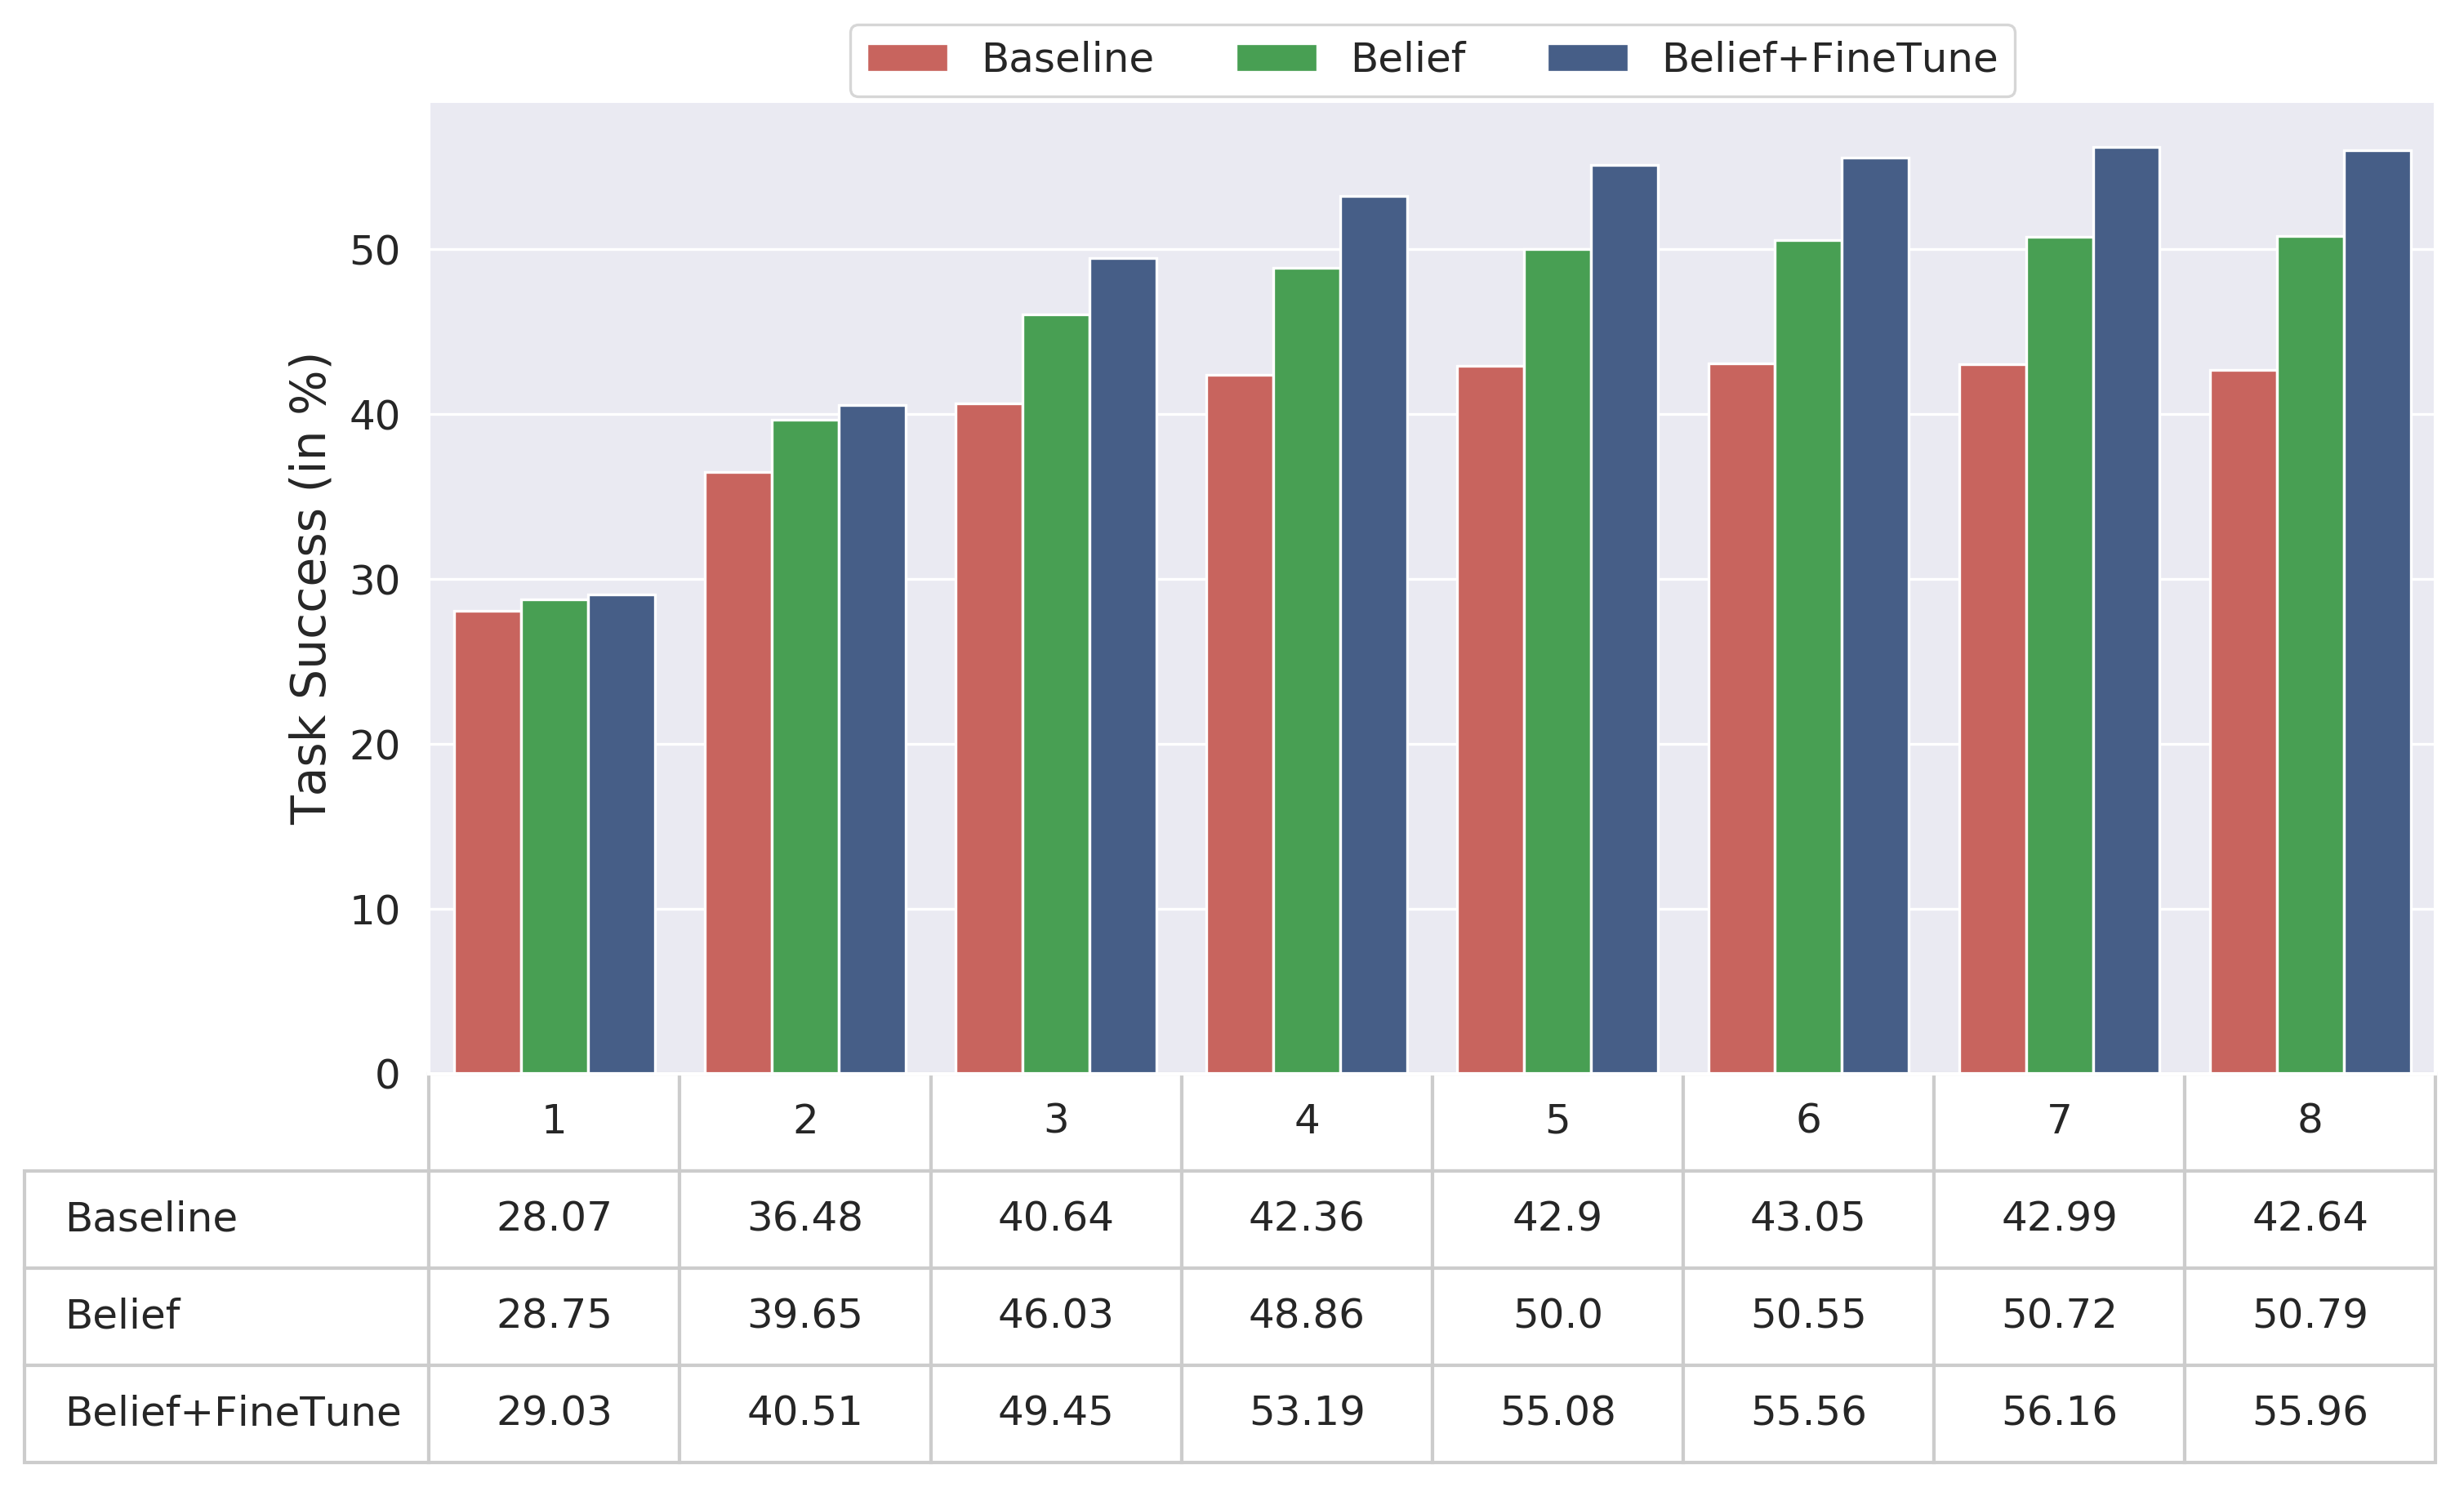

In [144]:
def plot_games_solved_by_round(data, nq=8):
    dfs = list()
    for label, d in data.items():
        counts = np.zeros((nq))
        for game in d.values():
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            for qi, op in enumerate(game[k][1:]):
                if np.argmax(op) == game['target_id']:
                    counts[qi] += 1
                
        probs = counts / len(data[label])
        df = pd.DataFrame(
            np.asarray([counts, probs]).reshape(2, -1).T, 
            columns=['counts', 'probs'], index=list(range(1, nq+1)))
        df['model'] = label
        df['i-th question'] = df.index
        dfs.append(df)

    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    ax = sns.barplot(data=df, x='i-th question', y="probs", hue='model', ax=ax)
    plt.yticks(np.arange(0, 0.51, 0.1), np.arange(0, 51, 10))
    #plt.xlabel('Question-Answer Pair')
    plt.xlabel('')
    plt.ylabel('Task Success (in %)')

    ax.legend(ax.get_legend_handles_labels()[0], ['Baseline', 'Belief', 'Belief+FineTune'],
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              fancybox=True, shadow=False, ncol=3, facecolor='white', prop={'size': 12})
    ax.tick_params('both', labelsize=12)
    
    table = plt.table(cellText=np.round(np.asarray(df['probs']).reshape(3, -1) * 100, 2) ,
                      rowLabels=['Baseline', 'Belief', 'Belief+FineTune'], colLabels=[''] * 8,
                      loc='bottom', bbox=[0,-0.4,1,0.4], cellLoc='center')
    
    table.set_fontsize(12)
    for key, cell in table.get_celld().items():
        cell.set_linewidth(1)
        cell.set_edgecolor('.8')

    plt.subplots_adjust(left=0.2, bottom=0.4)
    
    plt.show()
    
plot_games_solved_by_round(data)

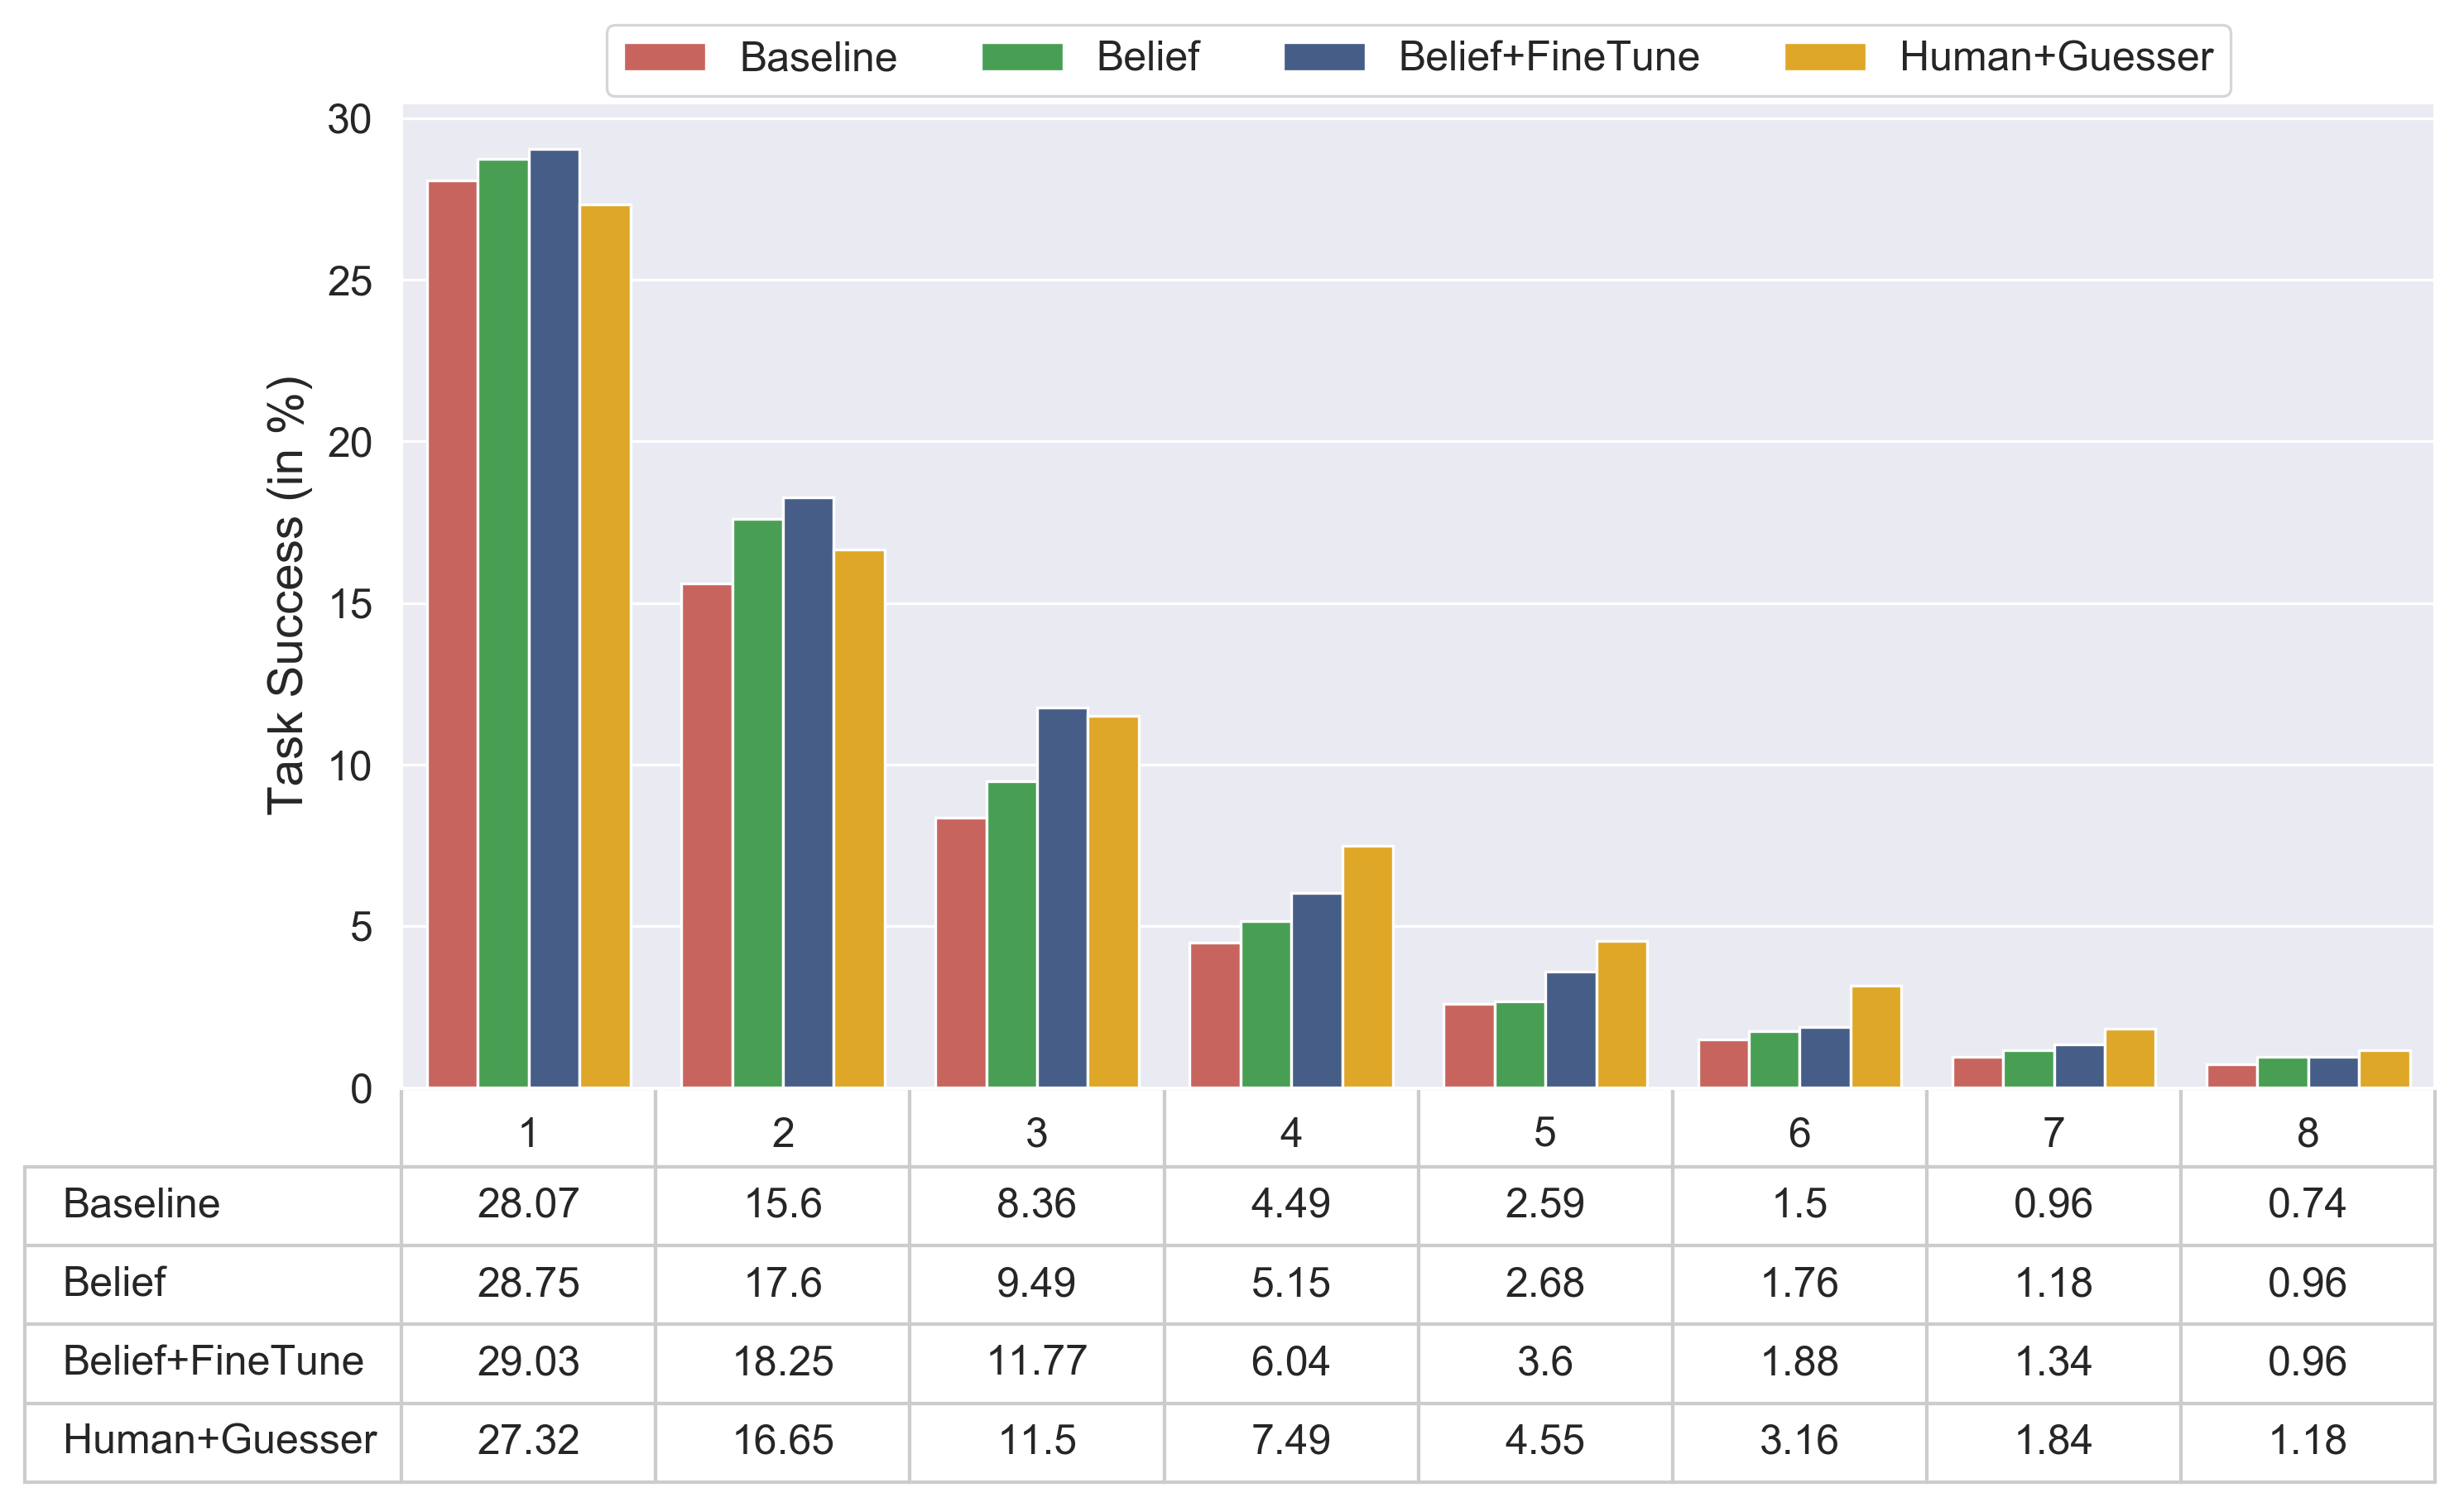

In [111]:
def plot_games_solved_by_round_first_time(data, guesser_data=None, nq=8):
    dfs = list()
    for label, d in data.items():
        counts = np.zeros((nq))
        for game in d.values():
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            for qi, op in enumerate(game[k][1:]):
                if np.argmax(op) == game['target_id']:
                    counts[qi] += 1
                    break
                
        probs = counts / len(data[label])
        df = pd.DataFrame(
            np.asarray([counts, probs]).reshape(2, -1).T, 
            columns=['counts', 'probs'], index=list(range(1, nq+1)))
        df['model'] = label
        df['i-th question'] = df.index
        dfs.append(df)
        
    if guesser_data is not None:
        counts = np.zeros(nq)
        for game_id, game in guesser_data.items():
            for i in range(1, min(nq+1, game['num_questions']+2)):
                if np.argmax(game['probs'][i]) == game['target_id']:
                    counts[i-1] += 1
                    break
                    
        probs = counts / len(guesser_data)
        df = pd.DataFrame(
            np.asarray([counts, probs]).reshape(2, -1).T, 
            columns=['counts', 'probs'], index=list(range(1, nq+1)))
        df['model'] = 'human-guesser'
        df['i-th question'] = df.index
        dfs.append(df)

    df = pd.concat(dfs)

    fig, ax = plt.subplots()
    ax = sns.barplot(data=df, x='i-th question', y="probs", hue='model', ax=ax)
    plt.yticks(np.arange(0, 0.35, 0.05), np.arange(0, 35, 5))
    plt.xlabel('')
    plt.ylabel('Task Success (in %)')

    ax.legend(ax.get_legend_handles_labels()[0], 
              ['Baseline', 'Belief', 'Belief+FineTune'] + ['Human+Guesser'] if guesser_data is not None else [],
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              fancybox=True, shadow=False, ncol=3 + 1 if guesser_data is not None else 0, facecolor='white', 
              prop={'size': 12})
    
    ax.tick_params('both', labelsize=12)
    
    table = plt.table(cellText=np.round(np.asarray(df['probs']).reshape(4, -1) * 100, 2) ,
                      rowLabels=['Baseline', 'Belief', 'Belief+FineTune', 'Human+Guesser'], colLabels=[''] * 8,
                      loc='bottom', bbox=[0,-0.4,1,0.4], cellLoc='center')
    
    table.set_fontsize(12)
    for key, cell in table.get_celld().items():
        cell.set_linewidth(1)
        cell.set_edgecolor('.8')
        #cell.set_facecolor("cyan")

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.4)
    
    plt.show()
    
plot_games_solved_by_round_first_time(data, guesser_data)

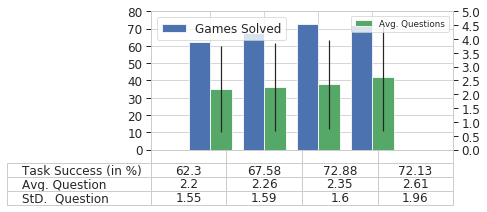

In [33]:
def num_question_oracle_score(data, guesser_data=None):
    
    
    records = list()
    
    for label, d in data.items():
        games_solved = 0
        num_q = list()
        for game in d.values():
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            for qi, op in enumerate(game[k][1:]):
                if np.argmax(op) == game['target_id']:
                    games_solved += 1
                    num_q.append(qi+1)
                    break
        records.append([label, games_solved, games_solved/len(d), np.mean(num_q), np.std(num_q)])
        # print(label, games_solved, games_solved/len(d), np.mean(num_q), np.std(num_q))
        
    if guesser_data is not None:
        games_solved = 0
        num_q = list()
        for game_id, game in guesser_data.items():
            for qi in range(1, min(13, game['num_questions']+1)):
                if np.argmax(game['probs'][qi]) == game['target_id']:
                    games_solved += 1
                    num_q.append(qi)
                    break
        records.append(["human-guesser", games_solved, games_solved/len(d), np.mean(num_q), np.std(num_q)])
        # print("human-guesser", games_solved, games_solved/len(d), np.mean(num_q), np.std(num_q))
        
    columns=["Model", "Num. Games Solved", "Games Solved", "Avg. Questions", "StD. Questions"]
    df = pd.DataFrame.from_records(records, columns=columns)

    df1 = df[["Model", "Games Solved"]]
    df2 = df[["Model", "Avg. Questions"]]
    
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    df1_len = len(df1.columns.values)
    df2_len = len(df2.columns.values)
    column_width = 0.8 / (df1_len + df2_len)

    df1_posi = 0.5 + (df2_len/float(df1_len)) * 0.5
    df2_posi = 0.5 - (df1_len/float(df2_len)) * 0.5

    df1.plot(kind='bar', rot=0, ax=ax, width=column_width*df1_len, 
             color=sns.color_palette()[:df1_len], position=df1_posi)
    df2.plot(kind='bar', rot=0, ax=ax2, width=column_width*df2_len,
             color=sns.color_palette()[df1_len:df1_len+df2_len], position=df2_posi, yerr=df["StD. Questions"])

    ax.legend(loc="upper left", prop={'size': 12})
    ax.tick_params('both', labelsize=12)
    ax2.tick_params('both', labelsize=12)

    ax2.grid(b=False, axis='both')

    column_length = (ax2.get_xlim()[1] - abs(ax2.get_xlim()[0])) / float(len(df1.index))
    ax2.set_xlim([ax2.get_xlim()[0] - column_length, ax2.get_xlim()[1] + column_length])

    ax.set_xticklabels(['Baseline', 'Belief', 'Belief+FineTune', 'Human+Guesser'])
    
    ax.set_yticks(np.arange(0, 0.81, 0.1))
    ax.set_yticklabels(np.arange(0, 81, 10))
    
    ax2.set_yticks(np.arange(0, 5.1, 0.5))
    ax2.set_yticklabels(np.arange(0, 5.1, 0.5))
    
    fig.patch.set_facecolor('white')
    
    cellText=np.asarray(df[["Games Solved", "Avg. Questions", "StD. Questions"]]).T
    cellText[0] = cellText[0]*100
    cellText = np.round(cellText, 2)
    table = plt.table(cellText=cellText ,
                      rowLabels=['Task Success (in %)', 'Avg. Question', 'StD.  Question'], colLabels=[''] * 8,
                      loc='bottom', bbox=[0,-0.4,1,0.4], cellLoc='center')
    
    table.set_fontsize(12)
    for key, cell in table.get_celld().items():
        cell.set_linewidth(1)
        cell.set_edgecolor('.8')

    plt.subplots_adjust(left=0.2, bottom=0.4)
    
    plt.show()
    
num_question_oracle_score(data, guesser_data)

/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


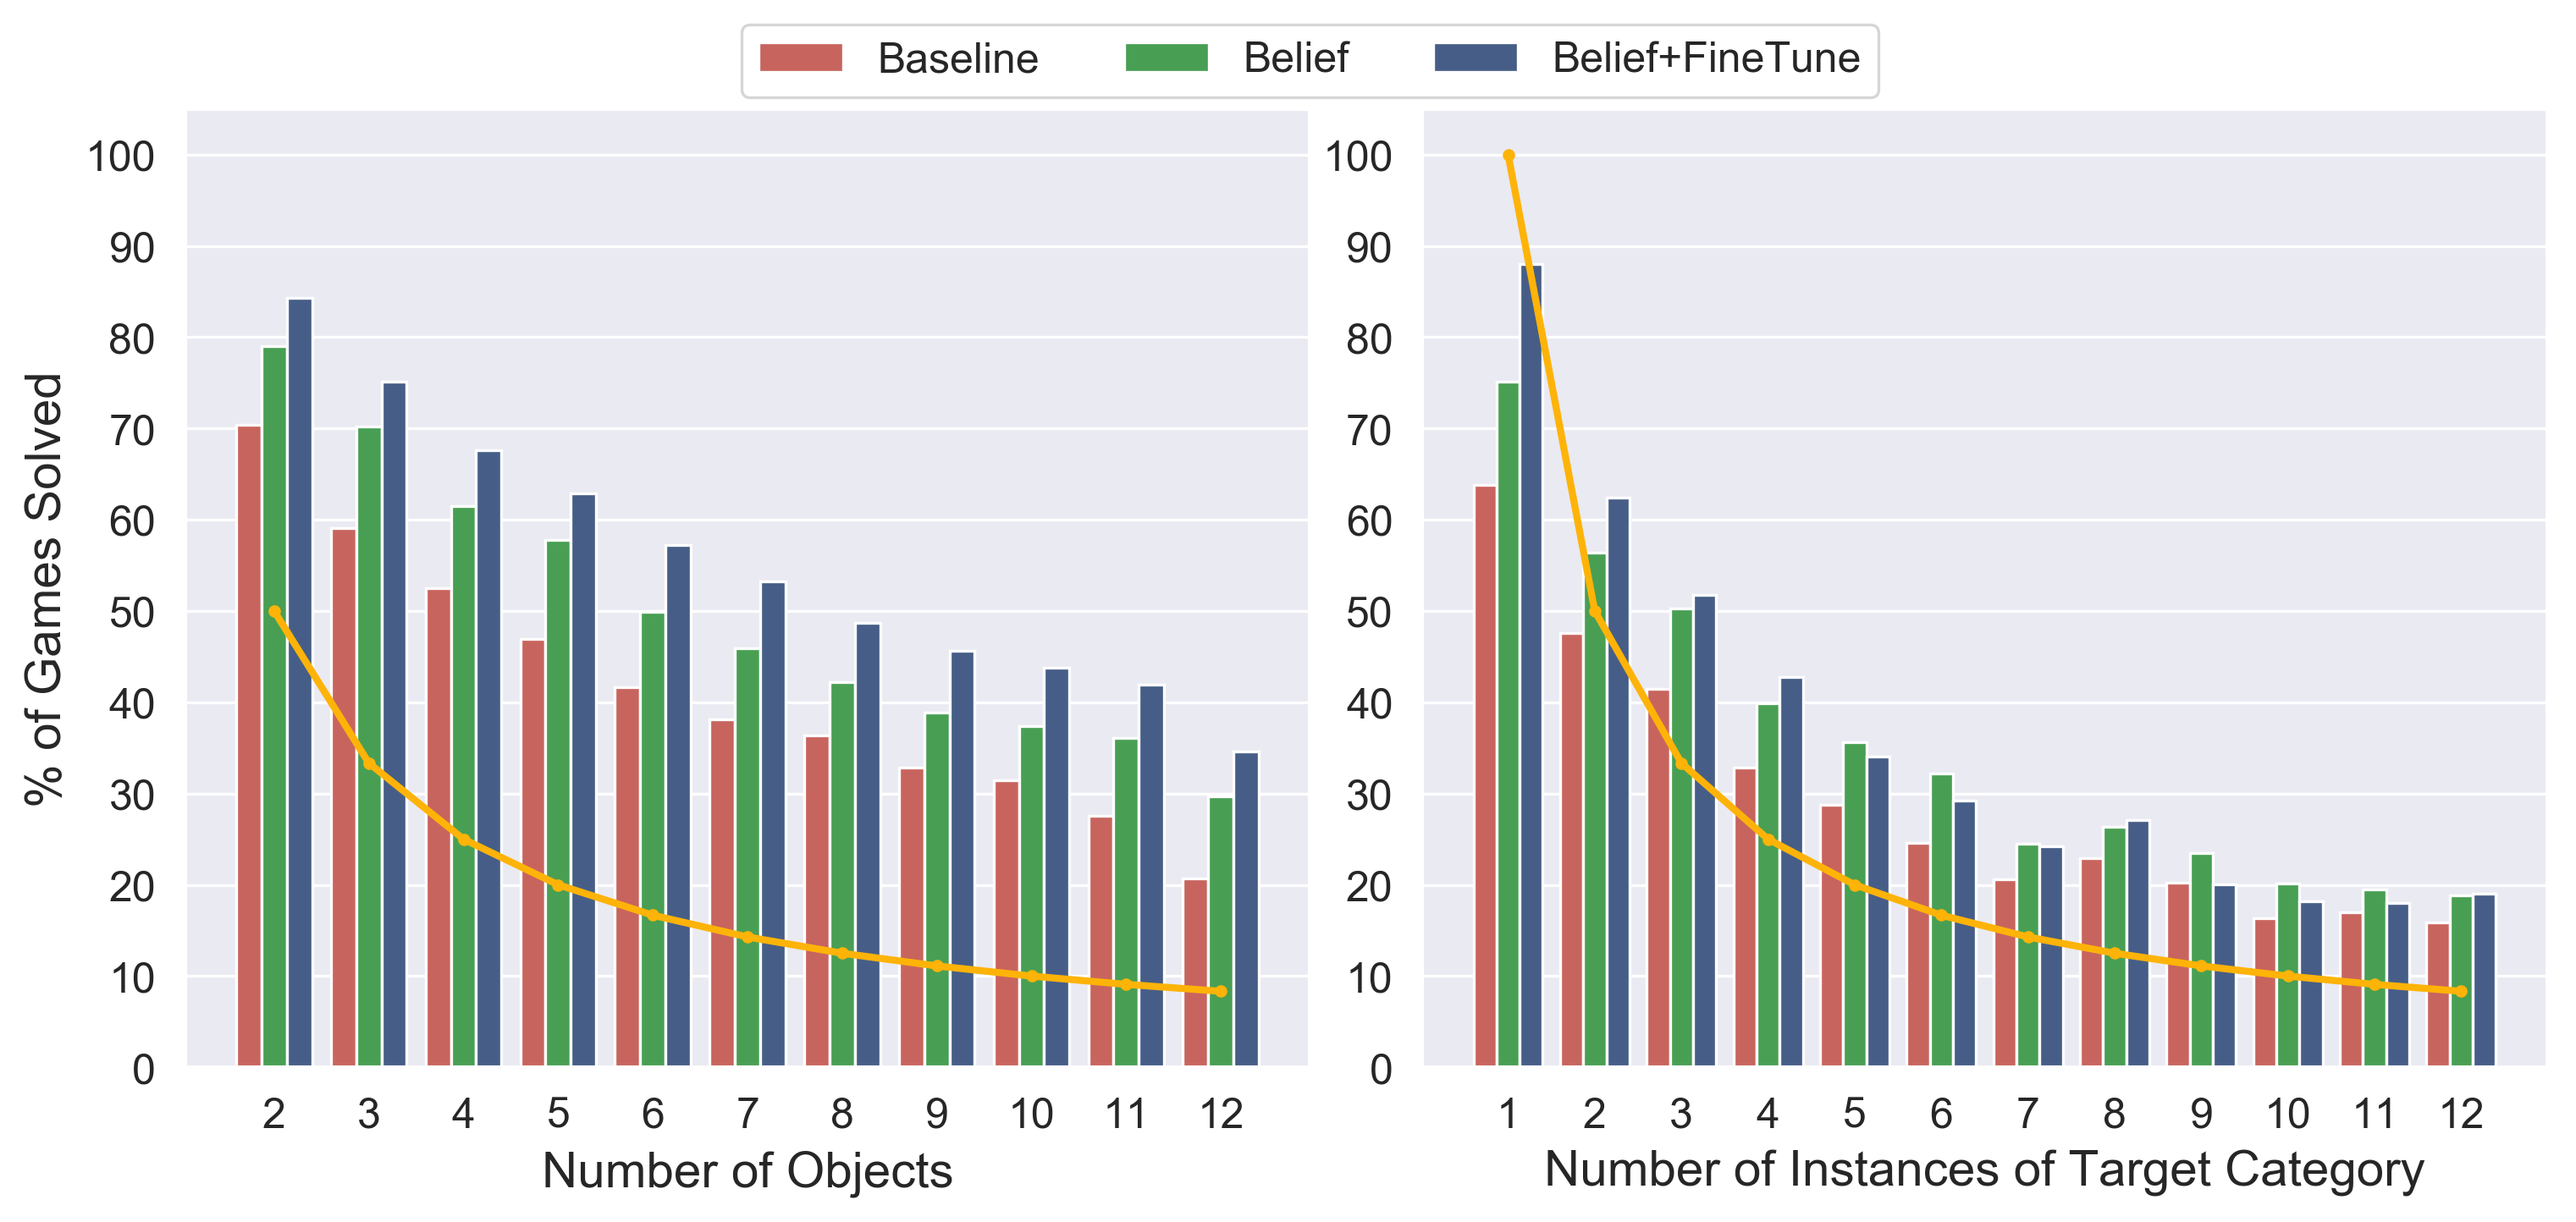

In [126]:
def solved_by_num_objects(data):
    
    
    games_by_num_objects = np.zeros(20)
    games_by_num_target_cat = np.zeros(20)
    solves = defaultdict(dict)
    dfs = list()
    r = True
    for label in data.keys():
        solves[label]['num_objects'] = np.zeros(20)
        solves[label]['num_target_cat'] = np.zeros(20)
        
        k = 'guesser_probs' if 'guesser_probs' in data[label][list(data[label].keys())[0]] else 'object_probs'
        for game in data[label].values():
            num_objects = len(game['object_categories'])
            target_category = game['object_categories'][game['target_id']]
            num_target_cat = game['object_categories'].count(target_category)
            solved = np.argmax(game[k][-1]) == game['target_id']
            if solved:
                solves[label]['num_objects'][num_objects-1] += 1
                solves[label]['num_target_cat'][num_target_cat-1] += 1
            
            if r:
                games_by_num_objects[num_objects-1] += 1
                games_by_num_target_cat[num_target_cat-1] += 1
        r = False

        solves[label]['num_objects'] = solves[label]['num_objects'] / games_by_num_objects
        solves[label]['num_target_cat'] = solves[label]['num_target_cat'] / games_by_num_target_cat
        
        x = np.vstack((solves[label]['num_objects'], solves[label]['num_target_cat'])).T
        
        df = pd.DataFrame(x, columns=['num_obj', 'num_tar_cat'], index=range(20))
        df['model'] = label
        dfs.append(df)
        
    # random        
    df = pd.concat(dfs)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    
    df_obj = df.drop([0, 1] + list(range(13, 20)))
    sns.barplot(x=df_obj.index, y='num_obj', hue='model', data=df_obj, ax=ax1)
    ax1.plot(np.arange(0, 11), 1/np.arange(2, 13), c=sns.xkcd_rgb['amber'], marker='.', linewidth=2, markersize=5)
    plt.xticks(np.arange(0, 12), np.arange(2, 13))
    ax1.set_yticks(np.arange(0, 1.01, 0.1))
    ax1.set_yticklabels(np.arange(0, 101, 10))
    ax1.set_xlabel('Number of Objects')
    ax1.set_ylabel('% of Games Solved')
    ax1.legend(ax1.get_legend_handles_labels()[0], ['Baseline', 'Belief', 'Belief+FineTune'] ,
              loc='upper center', bbox_to_anchor=(1, 1.11),
              fancybox=True, shadow=False, ncol=3, facecolor='white', prop={'size': 12})
    ax1.tick_params('both', labelsize=12)
    
    
    df_tar = df.drop(list(range(12, 20)))
    sns.barplot(x=df_tar.index, y='num_tar_cat', hue='model', data=df_tar, ax=ax2)
    ax2.plot(1/np.arange(1, 13), c=sns.xkcd_rgb['amber'], marker='.', linewidth=2, markersize=5)
    plt.xticks(np.arange(0, 12), np.arange(1, 13))
    plt.xlabel('Number of Instances of Target Category')
    ax2.set_yticks(np.arange(0, 1.01, 0.1))
    ax2.set_yticklabels(np.arange(0, 101, 10))
    ax2.set_ylabel('')
    ax2.get_legend().remove()
    ax2.tick_params('both', labelsize=12)
    ax2.yaxis.set_tick_params(which='both', labelleft=True)
   
    plt.subplots_adjust(wspace=0.1)
    plt.show()
    
solved_by_num_objects(data)

In [35]:
def get_answers(dial):
    return re.findall(string=dial, pattern="<yes>|<no>")

def plot_yes_no_ratio(data):

    dfs = list()
    for label, d in data.items():
        counts = np.zeros((8, 3))
        norm = 0
        for game in d.values():
            answers = get_answers(game['dialogue'])
            for i, ans in enumerate(answers):
                if ans == '<yes>':
                    counts[i, 0] += 1
                elif ans == '<no>':
                    counts[i, 1] += 1
                else:
                    counts[i, 2] += 1
        
        df = pd.DataFrame(counts, columns=['yes', 'no', 'n/a'], index=list(range(1, 8+1)))
        df['model'] = label
        df['i-th question'] = df.index
        dfs.append(df)
        
    df = pd.concat(dfs)
    
    return df
df=plot_yes_no_ratio(data)

In [36]:
sns.lineplot(data=df, hue='model', x='i-th question', y='yes-no-ratio', err_style='bars', ci=68)
plt.show()

ValueError: Could not interpret input 'yes-no-ratio'

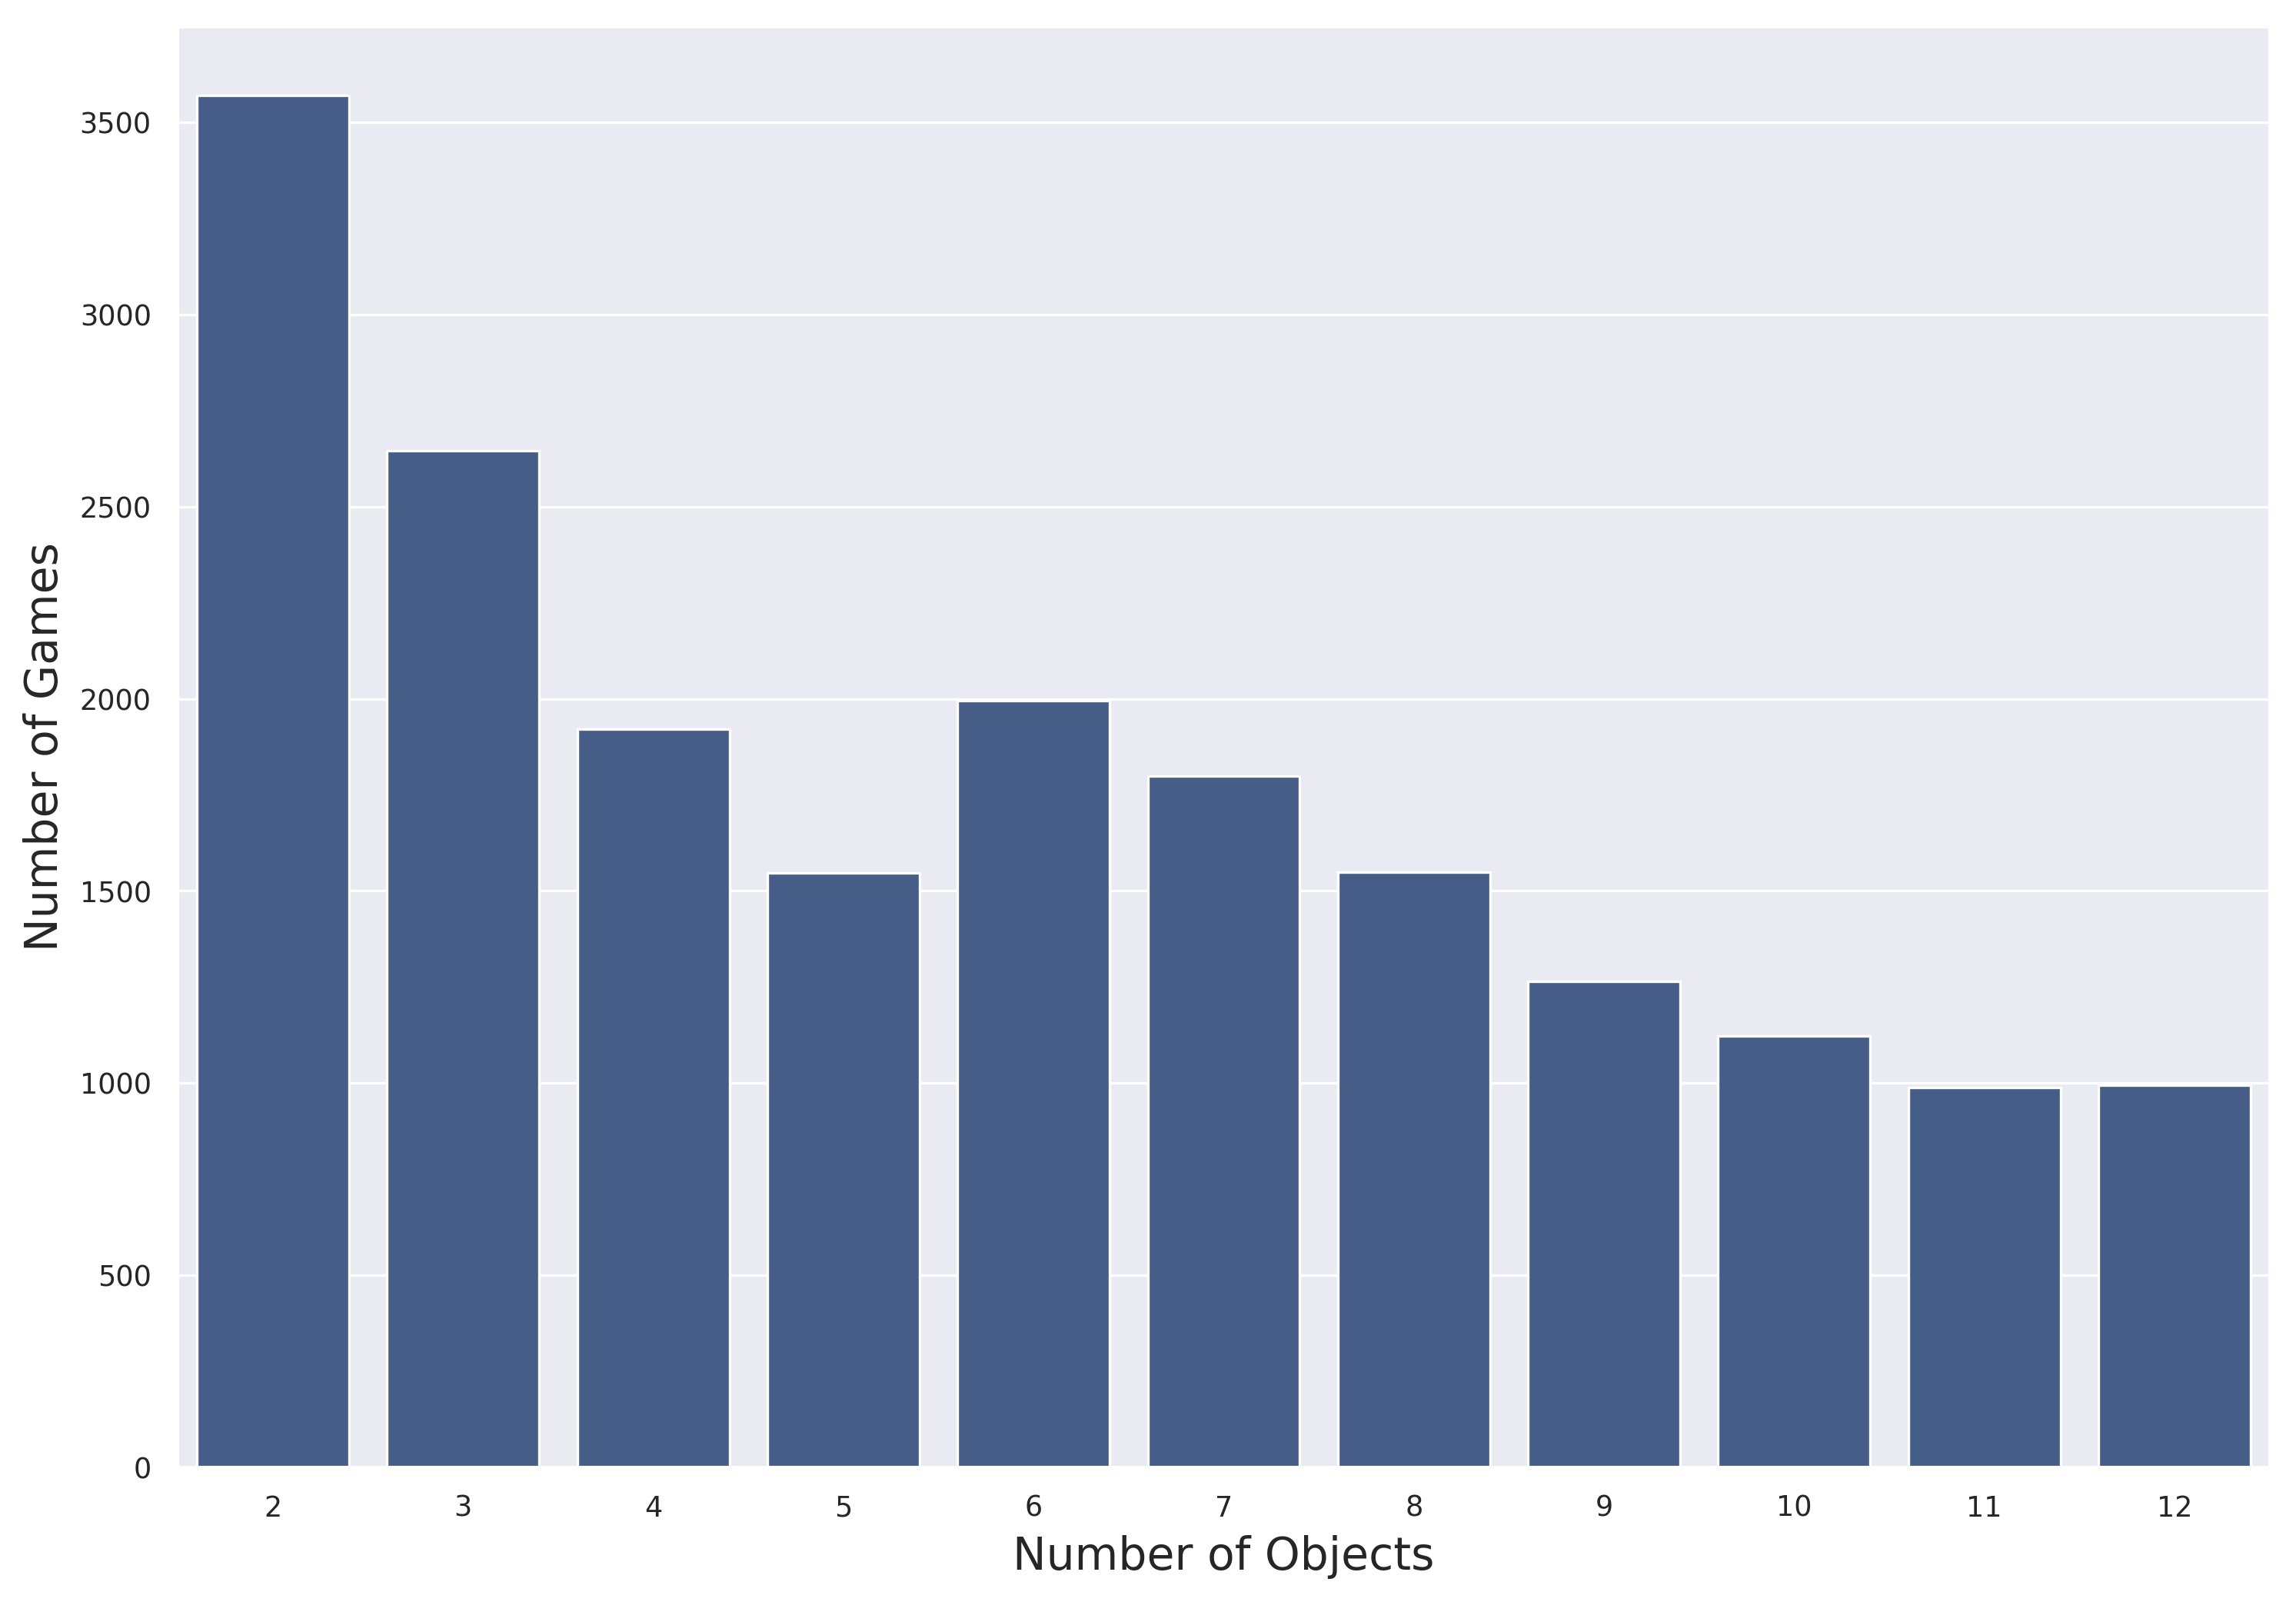

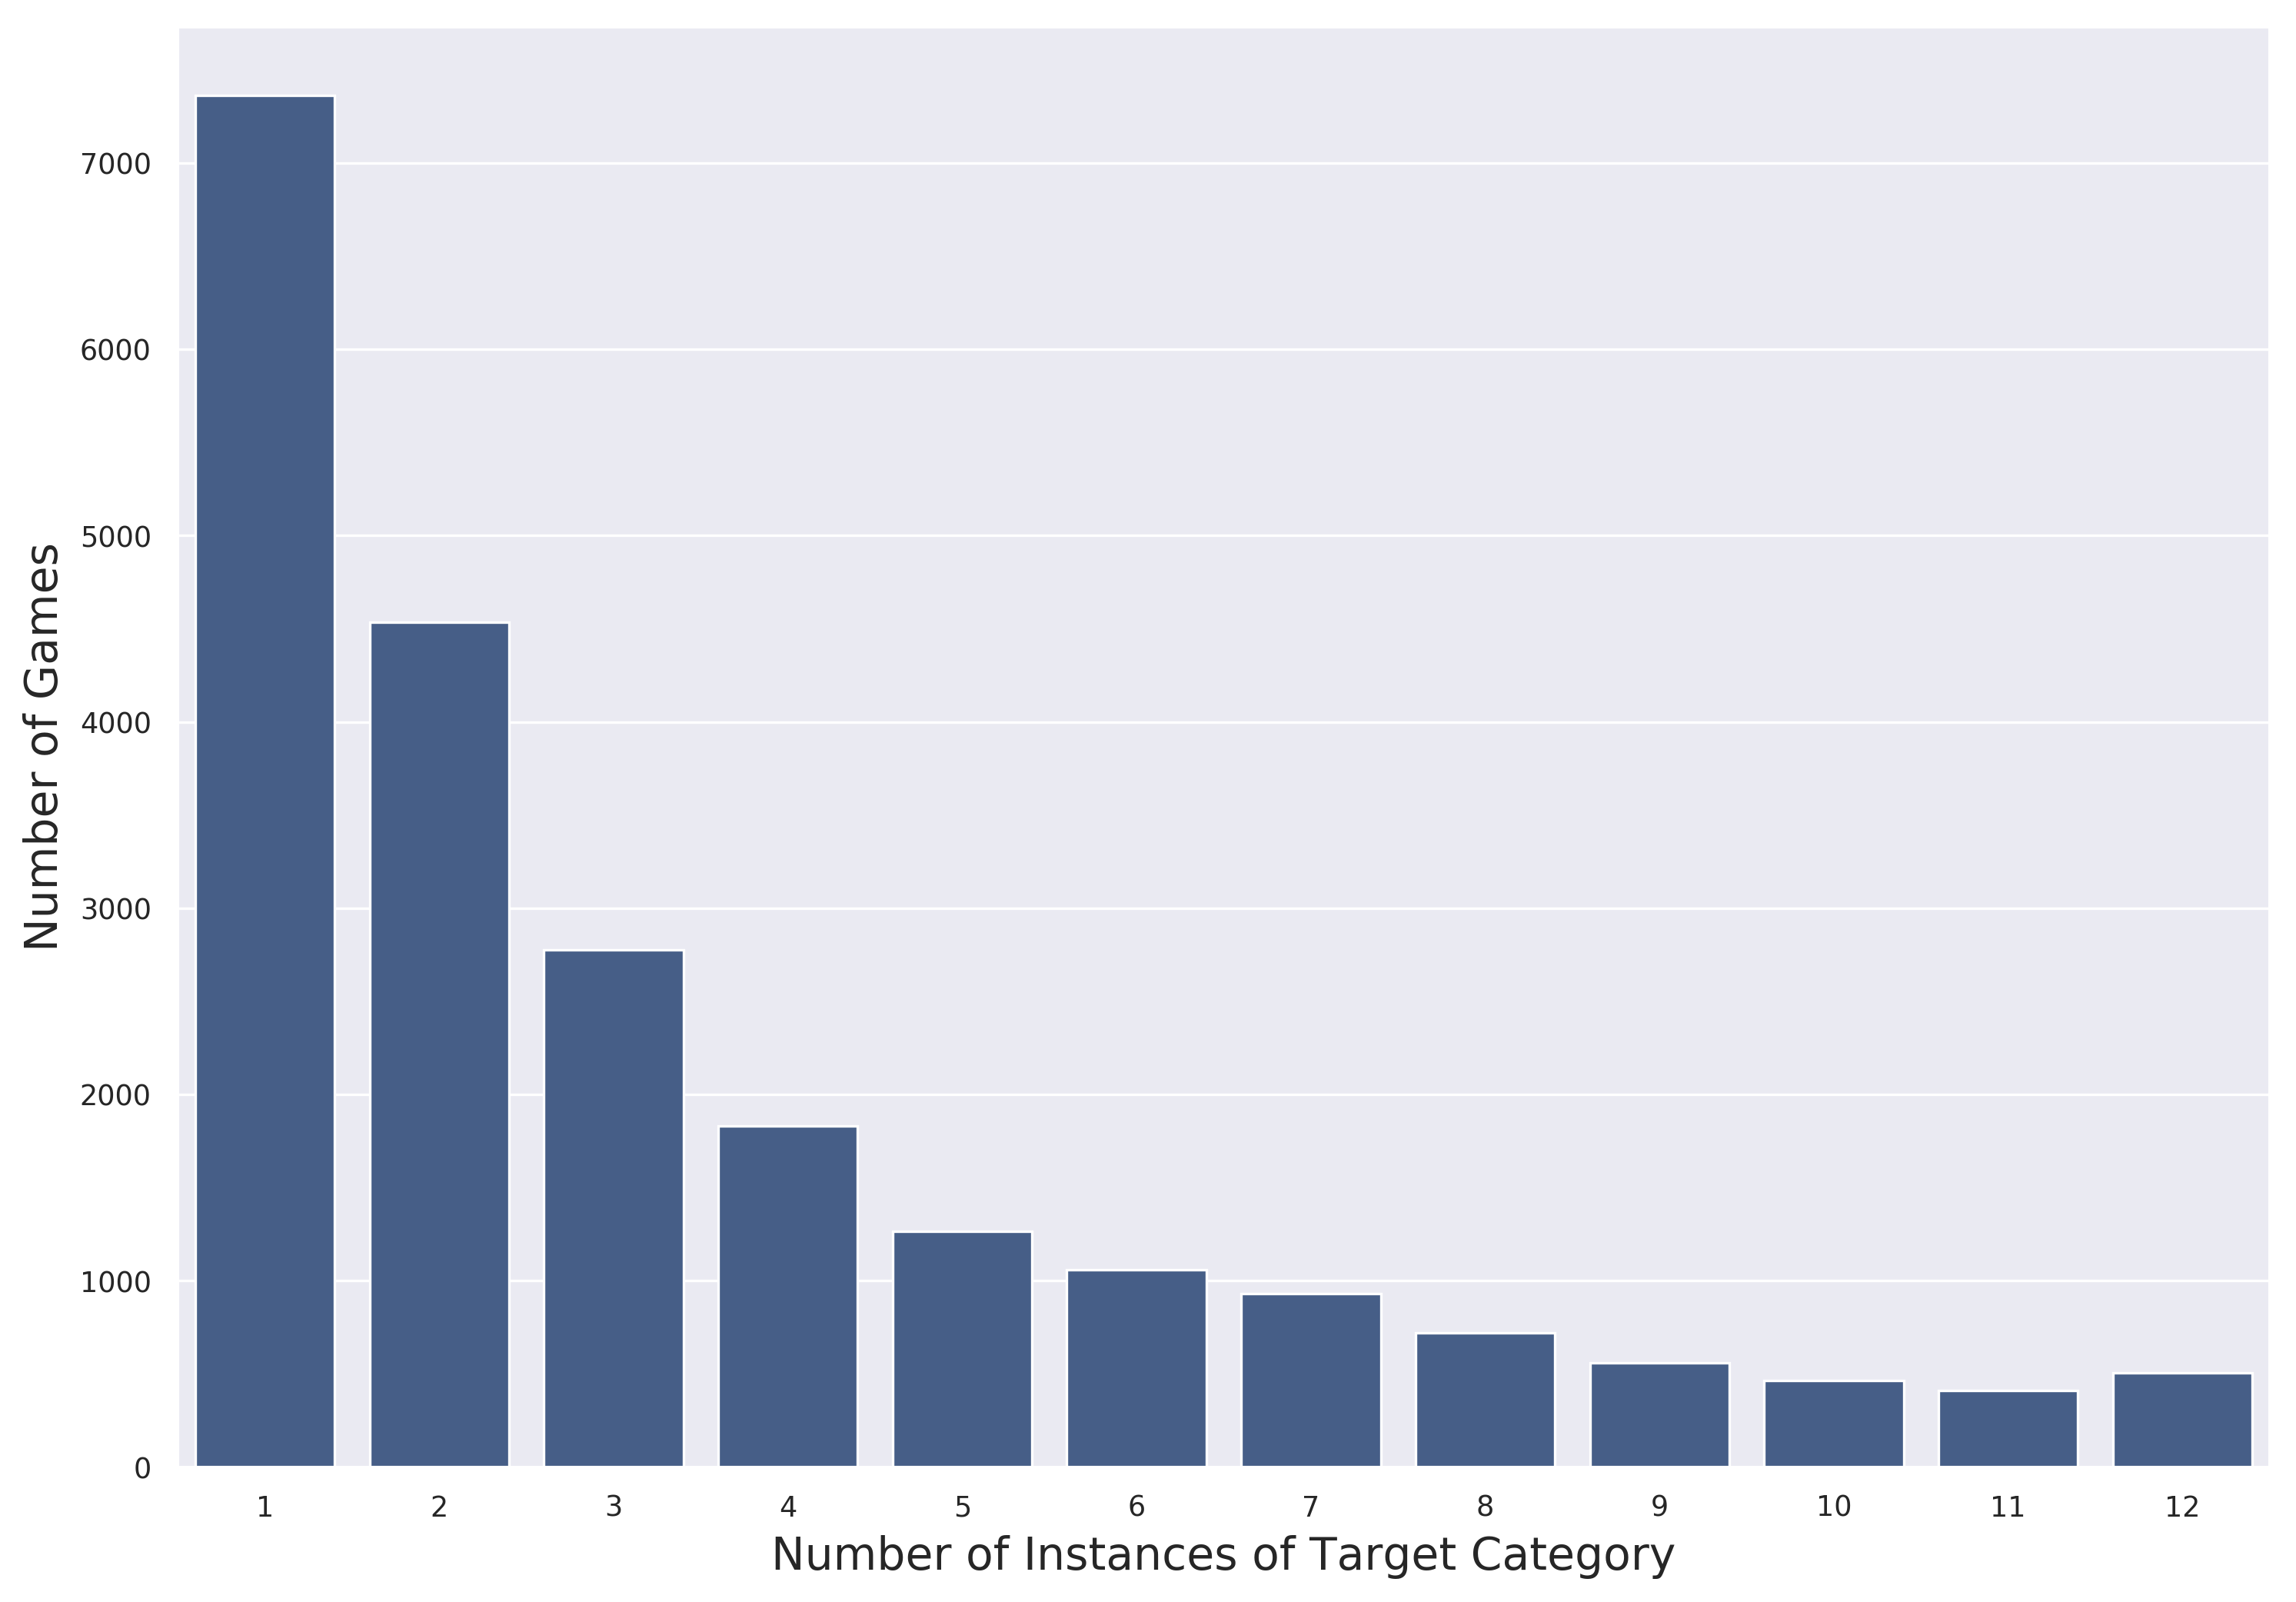

In [143]:
def num_games_by_num_obj(data):
    
    games_by_num_objects = np.zeros(20)
    games_by_num_target_cat = np.zeros(20)

    for game in data['baseline'].values():
        num_objects = len(game['object_categories'])
        num_target_cat = game['object_categories'].count(game['object_categories'][game['target_id']])
        games_by_num_objects[num_objects-1] += 1
        games_by_num_target_cat[num_target_cat-1] += 1
            
    df = pd.DataFrame.from_dict({'num_obj':games_by_num_objects})
    #print(df)
    fig, ax = plt.subplots()
    sns.barplot(x=df.index, y='num_obj', data=df, ax=ax, color=sns.color_palette()[2])
    plt.xlim(1.5, 12.5)
    plt.xticks(np.arange(2, 13), np.arange(2, 13))
    plt.xlabel('Number of Objects')
    plt.ylabel('Number of Games')
    plt.show()
    
    df = pd.DataFrame.from_dict({'num_tar':games_by_num_target_cat})
    #print(df)
    fig, ax = plt.subplots()
    sns.barplot(x=df.index, y='num_tar', data=df, ax=ax, color=sns.color_palette()[2])
    plt.xlim(-0.5, 11.5)
    plt.xticks(np.arange(0, 12), np.arange(1, 13))
    plt.xlabel('Number of Instances of Target Category')
    #plt.ylim(0, 5000)
    plt.ylabel('Number of Games')
    plt.show()
    
num_games_by_num_obj(data)

In [ ]:
def guesser_conf_matrix(data, nq=8):
    
    confusion = np.zeros((len(categories), len(categories)))
    for game in data.values():
        if game['target_id'] != game['prediction']:
            game_categories = game['object_categories']
            pred_category = game_categories[np.argmax(np.asarray(game['object_probs'][nq]))]
            true_category = game_categories[game['target_id']]
            if pred_category != true_category:
                confusion[categories.index(true_category), categories.index(pred_category)] += 1
    
    return confusion

def plot_conf(conf):
    df_cm = pd.DataFrame(conf, index=categories, columns=categories)
    plt.figure(figsize = (20,14))
    sns.heatmap(df_cm,cbar=False, square=True, cmap='Reds', linewidths=1)
    
plot_conf(guesser_conf_matrix(data))

In [68]:
def repeated_questions(data):
    num_games_with_repeated = defaultdict(int)
    num_repeated = defaultdict(int)
    for label, d in data.items():
        for game in d.values():
            dial = split_dialogue(game['dialogue'])
            if len(dial) > len(set(dial)):
                num_games_with_repeated[label] += 1
                num_repeated[label] += len(dial) - len(set(dial))
    print(num_games_with_repeated)
    print(num_repeated)
    
    for k in num_games_with_repeated.keys():
        print(k, num_games_with_repeated[k] / (len(data[k])), num_repeated[k] / (len(data[k])*8))
            
repeated_questions(data)

defaultdict(<class 'int'>, {'baseline': 23540, 'belief': 22978, 'belief_guesserup': 23025})
defaultdict(<class 'int'>, {'baseline': 98694, 'belief': 84062, 'belief_guesserup': 83354})
baseline 0.991617170057711 0.5196828004549475
belief 0.9679430473061207 0.442636589578331
belief_guesserup 0.9699229116643499 0.43890854711655924


In [70]:
def repeated_questions_until_first_solve(data):
    num_games_with_repeated = defaultdict(int)
    num_repeated = defaultdict(int)
    norm = defaultdict(int)
    for label, d in data.items():
        for game in d.values():
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            for qi, op in enumerate(game[k][1:]):
                if np.argmax(op) == game['target_id']:
                    break      
            qi = min(8, qi+1)
            dial = split_dialogue(game['dialogue'])[:qi]
            norm[label] += len(dial)
            if len(dial) > len(set(dial)):
                num_games_with_repeated[label] += 1
                num_repeated[label] += len(dial) - len(set(dial))
                
    print(num_games_with_repeated)
    print(num_repeated)
    for k in num_games_with_repeated.keys():
        print(k, num_games_with_repeated[k] / (len(data[k])), num_repeated[k] / norm[k])
            
repeated_questions_until_first_solve(data)

defaultdict(<class 'int'>, {'baseline': 10655, 'belief': 9204, 'belief_guesserup': 7819})
defaultdict(<class 'int'>, {'baseline': 43714, 'belief': 32580, 'belief_guesserup': 27243})
baseline 0.44883946248788914 0.41997963222719675
belief 0.3877164160242639 0.3328531584270696
belief_guesserup 0.3293736046168752 0.29549645313144024


In [73]:
def repeated_questions_until_first_solve(data):
    num_games_with_repeated = defaultdict(int)
    num_repeated = defaultdict(int)
    norm = defaultdict(int)
    norm2 = defaultdict(int)
    for label, d in data.items():
        for game in d.values():
            if not game['success']:
                continue
            norm2[label] += 1
            k = 'guesser_probs' if 'guesser_probs' in game else 'object_probs'
            for qi, op in enumerate(game[k][1:]):
                if np.argmax(op) == game['target_id']:
                    break      
            qi = min(8, qi+1)
            dial = split_dialogue(game['dialogue'])[:qi]
            norm[label] += len(dial)
            if len(dial) > len(set(dial)):
                num_games_with_repeated[label] += 1
                num_repeated[label] += len(dial) - len(set(dial))
                
    print(num_games_with_repeated)
    print(num_repeated)
    for k in num_games_with_repeated.keys():
        print(k, num_games_with_repeated[k] / norm2[k], num_repeated[k] / norm[k])
            
repeated_questions_until_first_solve(data)

defaultdict(<class 'int'>, {'baseline': 1330, 'belief': 1280, 'belief_guesserup': 1152})
defaultdict(<class 'int'>, {'baseline': 2680, 'belief': 2327, 'belief_guesserup': 2133})
baseline 0.1313969571230982 0.11800968736239542
belief 0.10617120106171202 0.08763934920156674
belief_guesserup 0.08672086720867209 0.06856536693561349


In [45]:
pd.DataFrame({'baseline': 98694-43714, 'belief': 84062-32580, 'belief_guesserup': 83354-27243}, index=range(1))

baseline  belief  belief_guesserup
0     54980   51482             56111

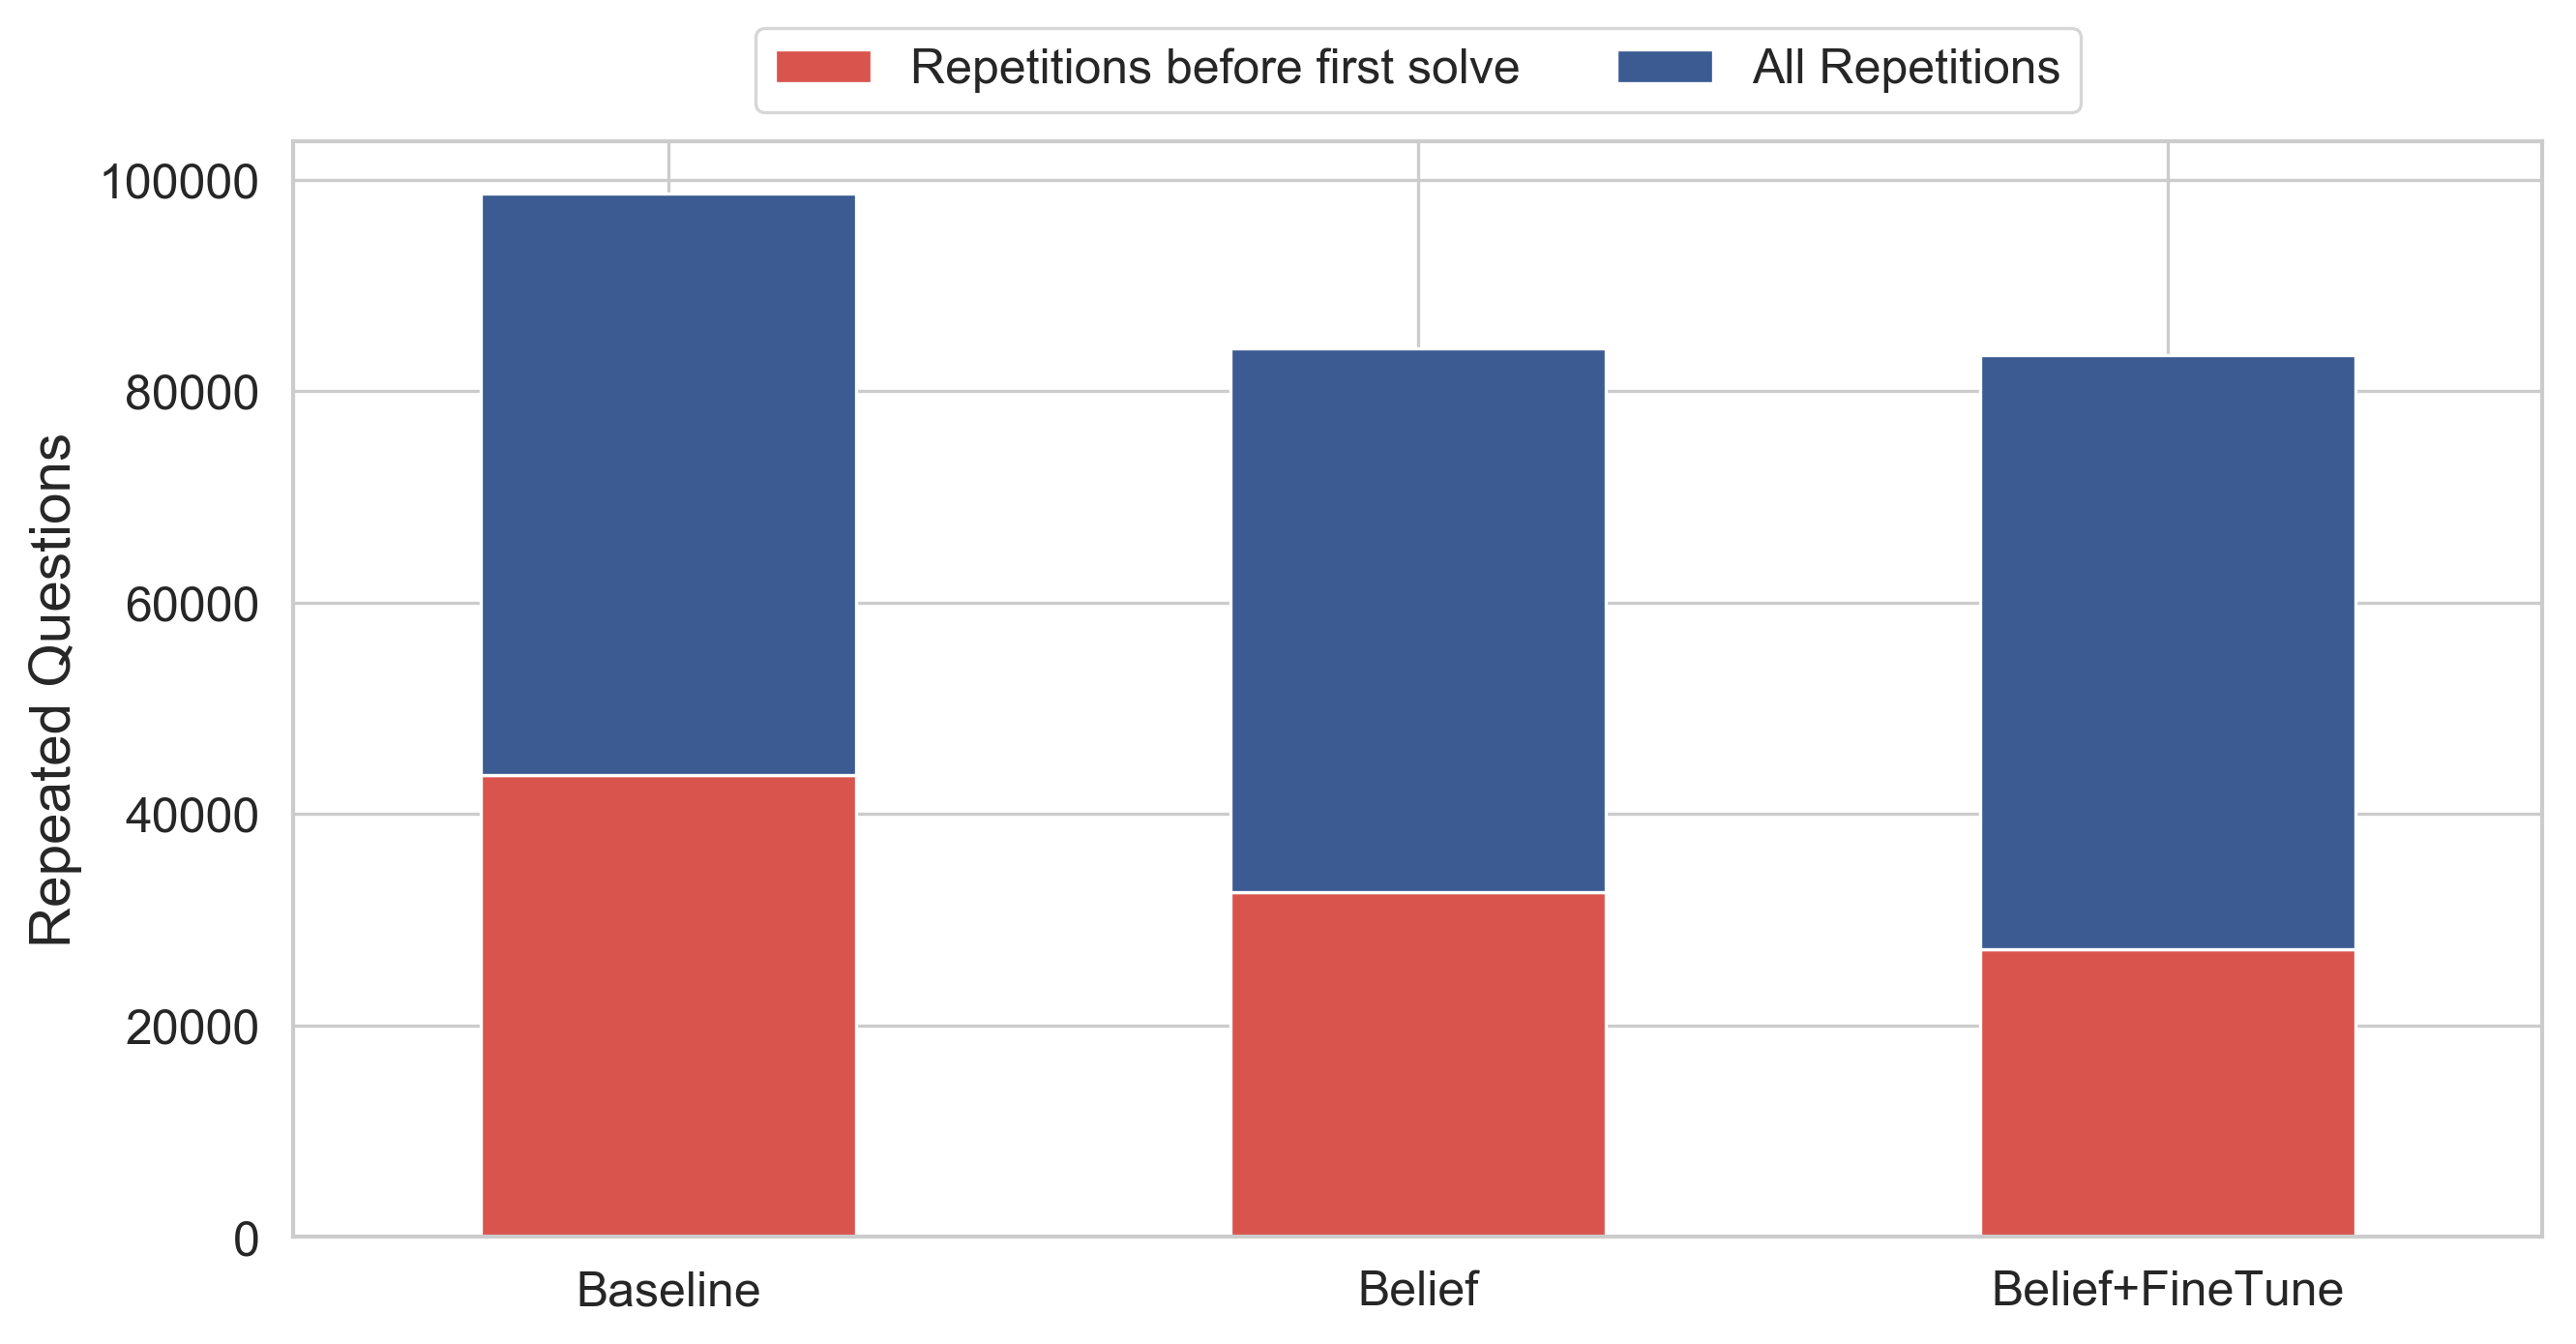

In [62]:
df = pd.concat(
    [pd.DataFrame(
            {'baseline': 43714, 'belief': 32580, 'belief_guesserup': 27243}, index=range(1)),
     pd.DataFrame(
             {'baseline': 98694-43714, 'belief': 84062-32580, 'belief_guesserup': 83354-27243}, index=range(1))])
fig, ax = plt.subplots(figsize=(10, 5))
ax = df.T.plot(kind='bar', rot=0,stacked=True, ax=ax, color=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]])
ax.set_ylabel('Repeated Questions')
ax.set_xticklabels(['Baseline', 'Belief', 'Belief+FineTune'])
ax.tick_params('both', labelsize=12)
ax.legend(ax.get_legend_handles_labels()[0], ['Repetitions before first solve', 'All Repetitions'],
              loc='upper center', bbox_to_anchor=(0.5, 1.125),
              fancybox=True, shadow=False, ncol=2, facecolor='white', prop={'size': 12})
plt.show()

In [ ]:
c_baseline = get_question_counter_per_round(data['baseline'])
c_belief = get_question_counter_per_round(data['belief'])
for i in range(8):
    print(i, len(c_baseline[i]), len(c_belief[i]), c_baseline[i].most_common(1), c_belief[i].most_common(1))

In [ ]:
nqs = [d['num_questions'] for d in guesser_data.values()]

In [ ]:
print("mean", np.mean(nqs))
print("std", np.std(nqs))

In [ ]:
def update(d, u, c):
        if len(u) > 1:
            update(d[u[0]], u[1:], c)
        else:
            try:
                d[u[0]] = d.get(u[0], 0) + c
            except:
                print(c)
        return d

def get_sun_data(qc, depth=4):
    
    tree = lambda: defaultdict(tree)
    sun = tree()

    for q, c in qc.items():
        words = q.split(' ')
        sun = update(sun, words[:depth], c)
                
    return sun

def get_sequences(sun, writer):
    
    def seq_count(d, writer, seq=[]):
        if isinstance(d, dict):
            for k in d.keys():
                seq_count(d[k], writer, (seq + [k]) if len(seq)>0 else [k])
        else:
            if d > 50:
                writer.writerow(seq + [d])
            
    writer = csv.writer(file, delimiter=',')
    seq_count(sun, writer)
    
for label in question_counters.keys():
    sun_data = get_sun_data(question_counters[label])
    with open('{}_sunburst.csv'.format(label), 'w') as file:
        get_sequences(sun_data, file)

In [ ]:
def p2f(x):
    return float(x.strip('%'))
task_succ = pd.read_csv(
    '/Users/timbaumgartner/Downloads/GuessWhat Belief - Sheet6 (1).csv', converters={'Task Accuracy Validation':p2f})

In [ ]:
sns.lmplot(hue='Setting', data=task_succ, x='Language Model CE', y='Task Accuracy Validation', fit_reg=False)
plt.yticks(np.arange(40, 60, 2.5), np.arange(40, 60, 2.5))
plt.ylim(40, 60)
plt.show()

In [97]:
norm = 0
c_super_cats, c_cats, c_colors, c_sizes, c_texture, c_shape, c_location = 0, 0, 0, 0, 0, 0, 0
for label in question_counters.keys():
    for q, c in question_counters[label].items():
        if set(q.split(' ')).intersection(set(super_cats)):
            c_super_cats += c

        if set(q.split(' ')).intersection(set(cats)):
            c_cats += c

        if set(q.split(' ')).intersection(set(colors)):
            c_colors += c

        if set(q.split(' ')).intersection(set(sizes)):
            c_sizes += c

        if set(q.split(' ')).intersection(set(texture)):
            c_texture += c

        if set(q.split(' ')).intersection(set(shape)):
            c_shape += c

        if set(q.split(' ')).intersection(set(location)):
            c_location += c

        norm += c
    print(label)    
    print("super categories", c_super_cats / norm)
    print("categories", c_cats / norm)
    print("colors", c_colors / norm)
    print("sizes", c_sizes / norm)
    print("texture", c_texture / norm)
    print("shape", c_shape / norm)
    print("location", c_location / norm) 
    print("-"*80)

baseline
super categories 0.26300602384262184
categories 0.5387495260962972
colors 0.08380197143940352
sizes 0.0
texture 7.898395046126628e-05
shape 0.0
location 0.3544536416866759
--------------------------------------------------------------------------------
belief
super categories 0.28989479337798557
categories 0.514533046884873
colors 0.07618791861493744
sizes 2.369518513837988e-05
texture 5.0023168625468635e-05
shape 0.0
location 0.37629270398921605
--------------------------------------------------------------------------------
belief_guesserup
super categories 0.26829970372242584
categories 0.5047864273979528
colors 0.07738847466194869
sizes 2.9838381285367257e-05
texture 0.00010180153615007652
shape 0.0
location 0.40183523596894
--------------------------------------------------------------------------------


In [167]:
import PIL.Image as Image

In [178]:
game_ids = list()
with gzip.open('../data/guesswhat.valid.jsonl.gz', 'r') as file:
    for json_game in file:
        game = json.loads(json_game)
        game_ids.append(game['id'])

In [179]:
from skimage import io
import matplotlib.patches as patches
mpl.rcParams.update(mpl.rcParamsDefault)

/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/timbaumgartner/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


[  5635 125592  63722 170089 116089]
COCO_val2014_000000469134.jpg
['person', 'person', 'person', 'person', 'person', 'person', 'car', 'person', 'motorcycle', 'motorcycle', 'motorcycle', 'person', 'person', 'motorcycle', 'person', 'person', 'person', 'motorcycle']
person


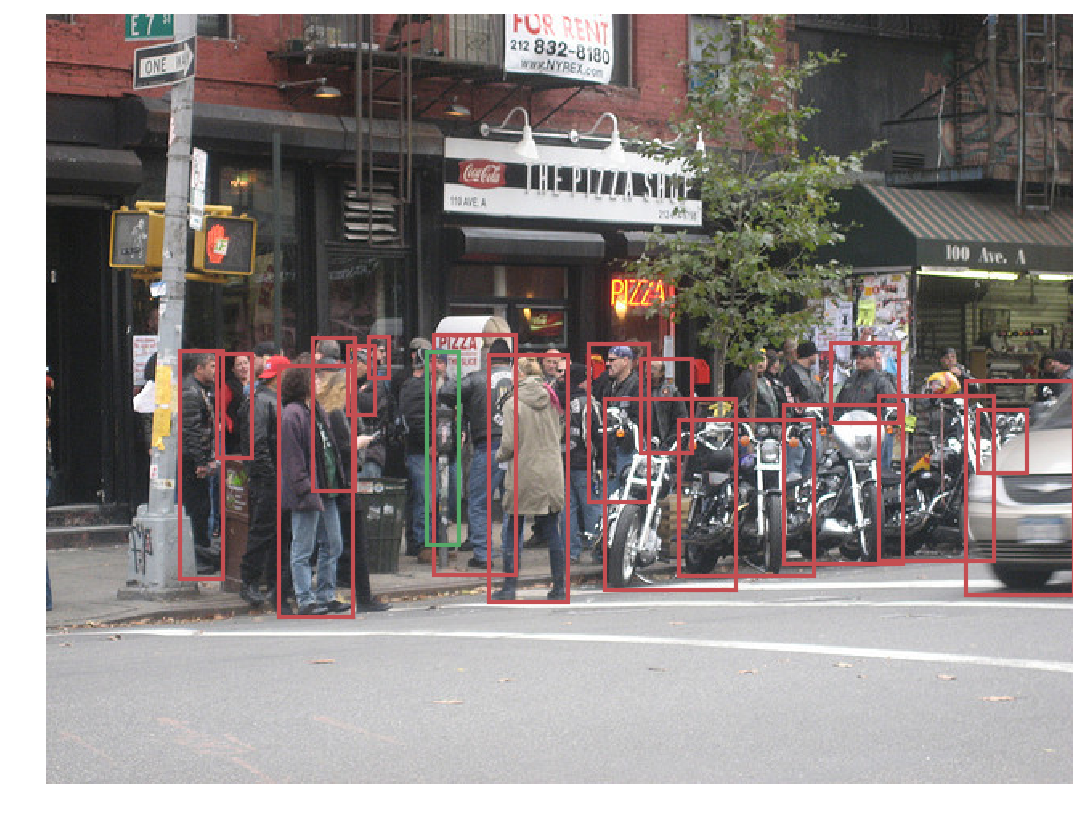

baseline is it a person? yes
 is it a woman? no
 is it a woman? no
 is it a woman? no
 is it a woman? no
 is it a woman? no
 is it a woman? no
 is it a woman? no False

belief is it a person? yes
 is it the person on the motorcycle? no is it the person on the motorcycle? no is it the person on the left? yes
 is it the person on the left? yes
 is it the whole person? yes
 is it the person on the left? yes
 is it the whole person? yes False

belief_guesserup is it a person? yes
 is it a man? yes
 is he wearing a hat? yes
 is he wearing a hat? yes
 is he wearing a hat? yes
 is he wearing a hat? yes
 is he wearing a hat? yes
 is he wearing a hat? yes False

COCO_train2014_000000170371.jpg
['dining table', 'cup', 'chair', 'chair', 'cup', 'cup', 'cup', 'chair', 'chair', 'chair', 'couch', 'vase', 'cup', 'cup']
cup


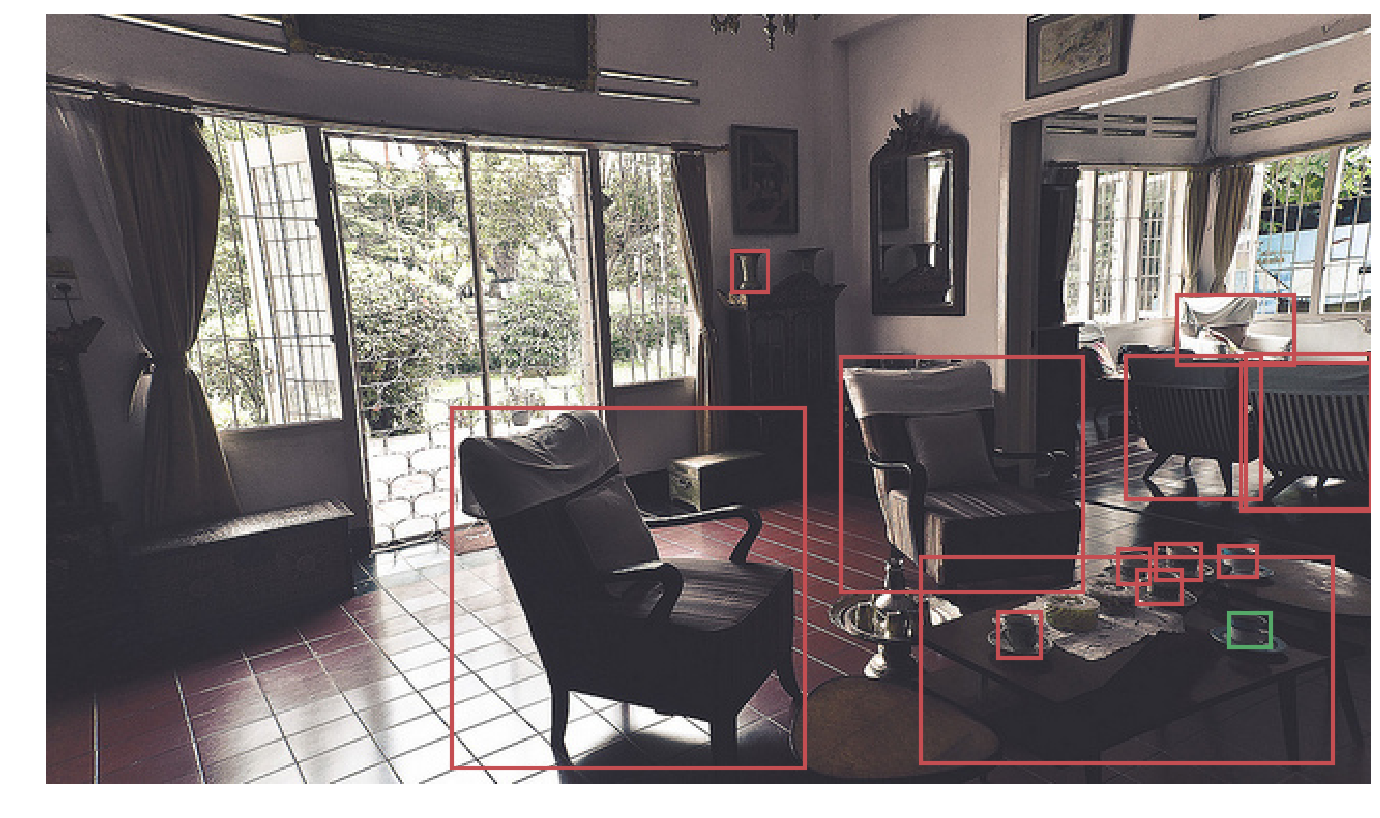

baseline is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no
 is it a piece of furniture? no False

belief is it a chair? no is it a table? no is it a glass? yes
 is it the one on the right? yes
 is it the one on the right? yes
 is it the one on the right? yes
 is it the one on the right? yes
 is it the one on the left? no True

belief_guesserup is it a chair? no
 is it a table? no
 is it a table? no
 is it a lamp? no
 is it a lamp? no
 is it a lamp? no
 is it a table? no
 is it a chair? no False

COCO_train2014_000000328348.jpg
['car', 'car', 'motorcycle', 'car']
motorcycle


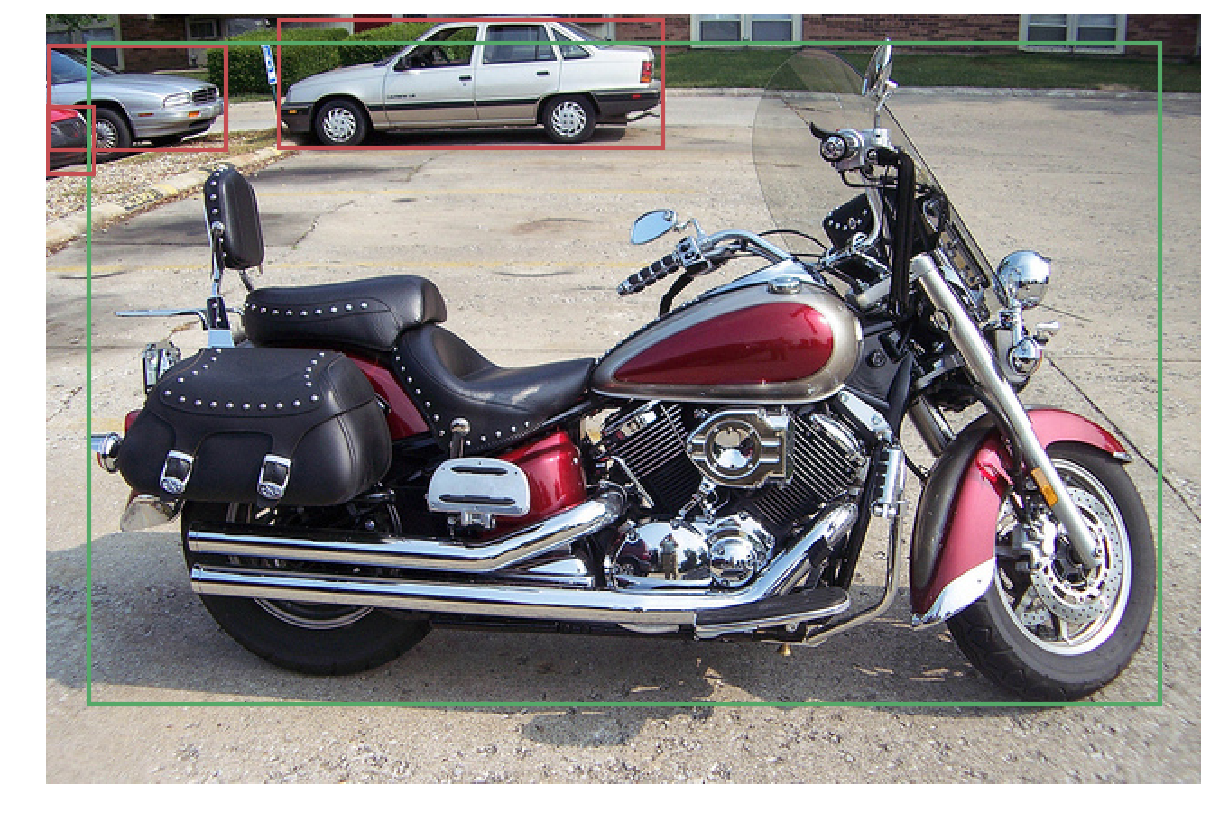

baseline is it a vehicle? yes
 is it the motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes True

belief is it a motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole bike? yes
 is it the whole bike? yes True

belief_guesserup is it a vehicle? yes
 is it a motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes
 is it the whole motorcycle? yes True

COCO_train2014_000000556011.jpg
['zebra', 'zebra', 'zebra', 'zebra', 'zebra']
zebra


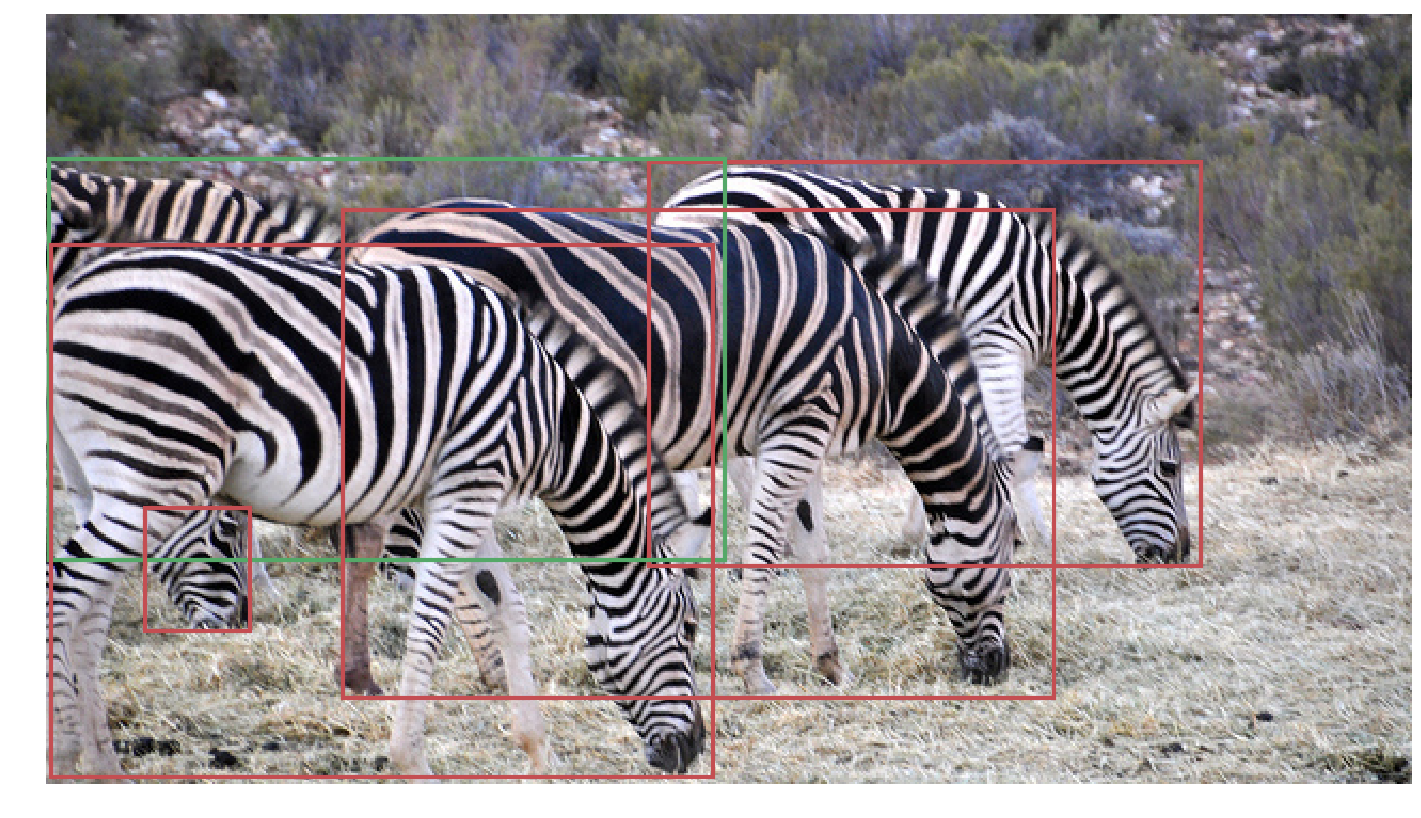

baseline is it a zebra? yes
 is it the one in the middle? no
 is it the one on the right? no
 is it the one on the right? no
 is it the one on the right? no
 is it the one on the right? no
 is it the one on the right? no
 is it the one on the right? no False

belief is it a zebra? yes
 is it the one on the left? yes
 is it the whole zebra? yes
 is it the whole zebra? yes
 is it the one on the left? yes
 is it the whole zebra? yes
 is it the whole zebra? yes
 is it the one on the left? yes False

belief_guesserup is it a zebra? yes
 is it the one on the left? yes
 is it the one in the middle? no is it the one on the right? no is it the one on the left? yes
 is it the one in the middle? no is it the one on the left? yes
 is it the one on the left? yes False

COCO_train2014_000000433235.jpg
['oven', 'person', 'refrigerator', 'person', 'bowl', 'person']
bowl


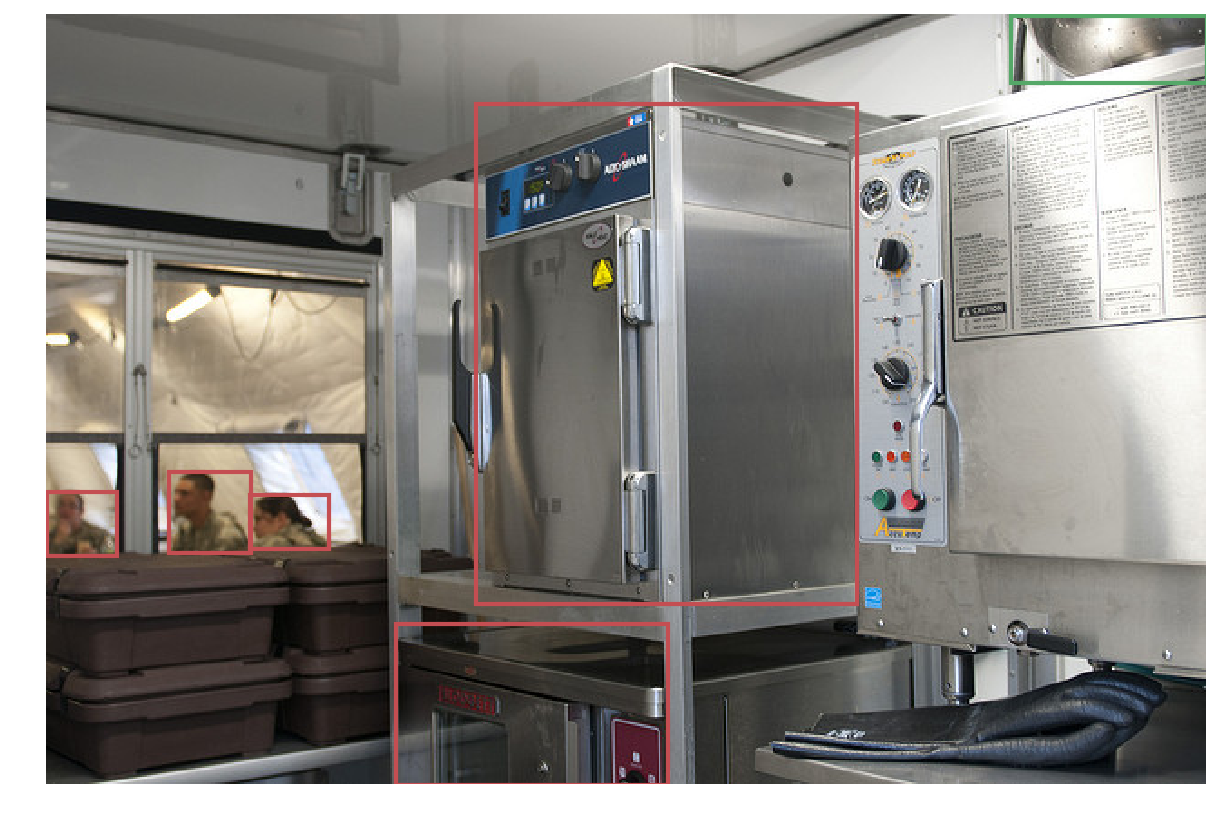

baseline is it a fridge? no
 is it a bottle? no
 is it a bottle? no
 is it a bottle? no
 is it a bottle? no
 is it a bottle? no
 is it a bottle? no
 is it a bottle? no True

belief is it a person? no
 is it the fridge? no
 is it the fridge? no
 is it on the fridge? no
 is it on the fridge? no
 is it the fridge? no
 is it the fridge? no
 is it the fridge? no False

belief_guesserup is it a person? no is it a fridge? no is it a stove? no is it a stove? no is it a fridge? no is it a bowl? yes
 is it the one with the white stuff in it? no
 is it the one with the white stuff in it? no True



In [225]:
np.random.seed(1)
g = np.random.choice(game_ids, size=5, replace=True)
print(g)
for game_id in g:

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(20, 10))
    #fig,ax = plt.subplots(1)
    try:
        if 'val' in data['baseline'][str(game_id)]['image_file']:
            d = 'val2014'
        else:
            d = 'train2014'
        image = Image.open('/Users/timbaumgartner/MSCOCO/' + d + '/'+data['baseline'][str(game_id)]['image_file'])
        print(data['baseline'][str(game_id)]['image_file'])
    except:
        print(data['baseline'][str(game_id)]['image_file'])
        print(data['baseline'][str(game_id)]['image_url'])
        raise
    # Display the image
    ax.imshow(image)

    
    # Create a Rectangle patch
    print(data['baseline'][str(game_id)]['object_categories'])
    for i, bbox in enumerate(data['baseline'][str(game_id)]['bbox']):
        if i == data['baseline'][str(game_id)]['target_id']:
            print(data['baseline'][str(game_id)]['object_categories'][i])
            c = 'g'
        else:
            c='r'
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=3,edgecolor=c,facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()
    for label in data.keys():
        dial = data[label][str(game_id)]['dialogue']

        suc = data[label][str(game_id)]['success']
        print(label, '\n'.join(split_dialogue_wo(dial)).replace('<', '').replace('>', '').replace(' ?', '?'), suc)
        print()
    

In [103]:
data['baseline']

'1.15.4'

In [223]:
def split_dialogue_wo(d):
    d = d[6:]
    d = re.findall('.*?<yes>|.*?<no>|.*?<n/a>', d)
    #d[-1] = d[-1][:d[-1].index('<')-1]
    #d = ' '.join(d).replace('<', '').replace('>', '').replace(' ?', '?')
    return d

d = "<sos> is it a person ? <yes> is it a woman ? <no> is it a woman ? <no> is it a woman ? <no> is it a woman ? <no> is it a woman ? <no> is it a woman ? <no> is it a woman ? <no>"
split_dialogue_wo(d)

['is it a person ? <yes>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>',
 ' is it a woman ? <no>']

In [12]:
b = torch.load('qgenbelief_guesserup_learnspat_ve128ce512_1549471823.507809.pt')

In [ ]:
from ..ut